# MNIST Standard Biological Images: Feed Forward Neural Network

In [189]:
import time
from datetime import datetime
import re
import numpy as np
import pandas as pd
#import seaborn as sns  # for nicer plots
#sns.set(style="darkgrid")  # default style
import tensorflow as tf
from tensorflow import keras
from keras import metrics
import numpy as np
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers, models, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
tf.get_logger().setLevel('INFO')

# Get date/time for local timezone
def get_localdate_str():
    tm_str = str(datetime.now())
    return tm_str

def get_time_with_minutes(date_str):
    tm_str = re.sub('^....-..-.. ', "", date_str)
    tm_str = re.sub(':..\.......$', "", tm_str)
    tm_str = re.sub(":", "-", tm_str)
    return tm_str

def get_date_with_seconds(date_str):
    tm_str = re.sub('\.......$', "", date_str)
    tm_str = re.sub(" ", "_", date_str)
    return tm_str

In [190]:
def display_confusion_matrix(y_tst, y_prd, ttl=None, sz=5, lbl=None):
    # Generate and display the confusion matrix
    cm = confusion_matrix(y_tst, y_prd)

    # Plot confusion matrix with labels
    fig, ax = plt.subplots(figsize=(sz,sz))
    
    if (lbl != None):
        im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        ax.figure.colorbar(im, ax=ax)

        # Set labels and title
        ax.set_xlabel('Predicted labels')
        ax.set_ylabel('True labels')

        # Set tick labels
        ax.set_xticks(np.arange(len(lbl)))
        ax.set_yticks(np.arange(len(lbl)))
        ax.set_xticklabels(lbl)
        ax.set_yticklabels(lbl)

        # Rotate x-tick labels
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

        # Add values to cells (optional)
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], 'd'),
                        ha="center", va="center",
                        color="white" if cm[i, j] > cm.max() / 2. else "black")
    else:
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues, ax=ax)

    # Customize plot
    plt.title(ttl)
    plt.show()

In [191]:
def get_data_set_dimensions(contained_array, data):
    x_shape = data.shape
    end_of_range = len(x_shape)
    #print("end_of_range:", end_of_range)

    dim = ""
    if end_of_range == 4:
        if x_shape[3] == 3:
            dim = "RGB images:"
        else:
            dim = "3D images: "
        dim = dim + str(x_shape[1]) + "x" + str(x_shape[2]) + "x" + str(x_shape[3])
    elif end_of_range == 3:
        dim = "2D images: " + str(x_shape[1]) + "x" + str(x_shape[2])
    if (dim != ""):
        print(f"  {contained_array}: {x_shape[0]} {dim}")

    return end_of_range

In [192]:
def flatten_data(contained_array, data, end_of_range):
    data_shape = data.shape
    
    if (end_of_range > 2):
        # Handle 2D, 3D, ... nD image dimensions
        flat_sz = 1
        for ix in range(1, end_of_range):
            flat_sz = flat_sz * data_shape[ix]
        #print("flat_sz:", flat_sz)
        data = data.reshape(-1, flat_sz)
    else:
        # Convert label dimensions to 1D
        data = np.ravel(data, order='C')
    return(data)

## Load data then flatten labels, images are flattened later within LR model

In [193]:
def load_and_flatten(fn):
    npz_file = np.load(fn, allow_pickle=True)
    #print(fn, "arrays:", blood_npz.files)

    # Dictionaries to store flattened image data
    flat_arr = {}
    label_arr = {}
    # Dictionary to store images (unflattened)
    orig_arr = {}
    
    substr = "labels"

    for contained_array in npz_file.files:
        # Only labels need to be flattened.
        # Features (images) will be flattened by the Logistic Regression model
        end_of_range = get_data_set_dimensions(contained_array, npz_file[contained_array])
        match = re.search(substr, contained_array)
        if (match):
            #print(f"  BEFORE: {contained_array}: {npz_file[contained_array].shape}")
            arr = flatten_data(contained_array, npz_file[contained_array], end_of_range)
            label_arr[contained_array] = arr
            #print(f"  {contained_array} (flattened): {label_arr[contained_array].shape}")
        else:
            orig_arr[contained_array] = npz_file[contained_array]
    
    return orig_arr, label_arr

## Build a Keras Logistic Regression model using a single Dense layer

In [194]:
def build_model(n_classes,
                img_dim,
                hidden_layer_sizes=[],
                activation='relu',
                optimizer='adam',
                learning_rate=0.01):

    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)

    # Keras logistic regression has input and output layers with as a single Dense layer.
    # So hidden_layer will be 0 for this model

    hidden_layers = len(hidden_layer_sizes)
    ix = 0
    model = keras.Sequential()
    model.add(keras.Input(shape=img_dim)),
    model.add(Flatten())
    while(hidden_layers != 0):
        model.add(Dense(hidden_layer_sizes[ix], activation=activation))
        ix += 1
        hidden_layers -= 1
    model.add(Dense(n_classes, activation='softmax')) # Output layer with n-classes
    # Display the model summary to see the architecture
    model.summary()
    
    # Compile the model using the Adam optimizer
    #model.compile(optimizer='adam',
    model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                #loss='categorical_crossentropy',
                metrics=['accuracy'],
            )
    return model

In [195]:
def process_file(fn):

    #result_dict = {}
    csv_data = [[]]
    print("\n-------------------------------------------------------")
    print(fn)
    original_imgs, labels = load_and_flatten(fn)
    feature_keys = list(original_imgs.keys())
    #print(feature_keys)
    label_keys = list(labels.keys())
    #print(label_keys)
    
    img_shape = original_imgs[feature_keys[0]].shape
    img_dim = []
    for ix in range(1, len(img_shape)):
        img_dim.append(img_shape[ix])
    #print("img_dim:", img_dim)

    X_train = original_imgs[feature_keys[0]]
    y_train = labels[label_keys[0]]
    X_test = original_imgs[feature_keys[2]]
    y_test = labels[label_keys[2]]

    # Find number of unique classes within data set
    class_cnt, value_cnts = np.unique(labels[label_keys[0]], return_counts=True)
    #print(f"class_cnt: {class_cnt}")
    #print(f"value_cnts: {value_cnts}")
    n_classes = len(class_cnt)
    #print(f"n_classes: {n_classes}")

    # Display the first image and label in the training data
    print("\nLabel: ", y_train[0])
    if len(img_dim) < 3 or img_dim[2] == 3:
        #img_arr = original_imgs[feature_keys[0]]
        img = X_train[0]
        plt.imshow(img)
        plt.axis('off')
        plt.show()

    # Build model and train with a variety of learning rates and epochs for each data set
    for learning_rate in [0.1, 0.01, 0.001]:
        
        # Build the Feed Forward Neural Network Model
        kerasLR = build_model(n_classes, img_dim, [128, 64, 64], 'relu', 'adam', learning_rate)
        
        for num_epochs in [25, 50, 100, 150]:

            
            ttl = fn + ": Epochs " + str(num_epochs) + ", LR " + str(learning_rate)
            # Train the Logistic Regression model.
            print(f'\nTraining... {ttl}')
            start = time.time()
            history = kerasLR.fit(
                x=X_train,
                y=y_train,
                epochs=num_epochs,
                batch_size=64,
                validation_split=0.1,
                validation_data=(X_test, y_test),
                verbose=0)
            trn_elapsed = time.time() - start

            train_accuracy = history.history['accuracy']
            val_accuracy = history.history['val_accuracy']
            plt.plot(train_accuracy, label='train_accuracy')
            plt.plot(val_accuracy, label='validation accuracy')
            #plt.xticks(range(num_epochs))
            plt.xlabel('Training epochs')
            plt.ylabel('Accuracy')
            plt.title(ttl)
            plt.legend()
            plt.show()

            # Evaluate the model and determine final accuracy
            start = time.time()
            #test_accuracy = kerasLR.evaluate(x=X_test, y=y_test, verbose=0,
            #                             return_dict=True)['accuracy']
            loss, test_accuracy = kerasLR.evaluate(x=X_test, y=y_test, verbose=0)
            eval_elapsed = time.time() - start
        
            print(f"Training time: {round(trn_elapsed, 2)} seconds")
            print(f"Evaluation time: {round(eval_elapsed, 2)} seconds")
            print(f"Accuracy: {round(test_accuracy * 100, 3)}, Loss: {round(loss, 5)}, Epochs: {num_epochs}, LR {learning_rate}")
            #run_result = { 'lr' : learning_rate, 'ep' : num_epochs, 'acc' : test_accuracy, 'loss' : loss, \
            #                       'ttime' : trn_elapsed }
            #result_dict[ttl] = run_result
            csv_row = np.array([fn, learning_rate, num_epochs, round(test_accuracy * 100, 2), \
                                round(loss, 5), round(trn_elapsed, 2)])
            csv_data.append(csv_row)

            #print(result_dict)
            
    return csv_data


-------------------------------------------------------
bloodmnist.npz
  train_images: 11959 RGB images:28x28x3
  val_images: 1712 RGB images:28x28x3
  test_images: 3421 RGB images:28x28x3

Label:  7


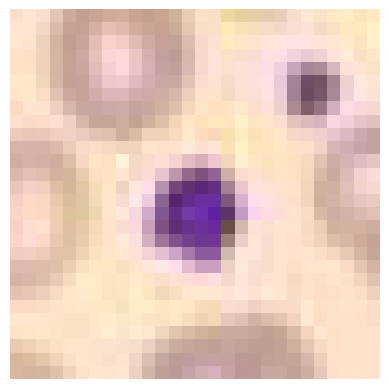

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 2352)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         301,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 314,120 (1.20 MB)

 Trainable params: 314,120 (1.20 MB)

 Non-trainable params: 0 (0.00 B)


Training... bloodmnist.npz: Epochs 25, LR 0.1


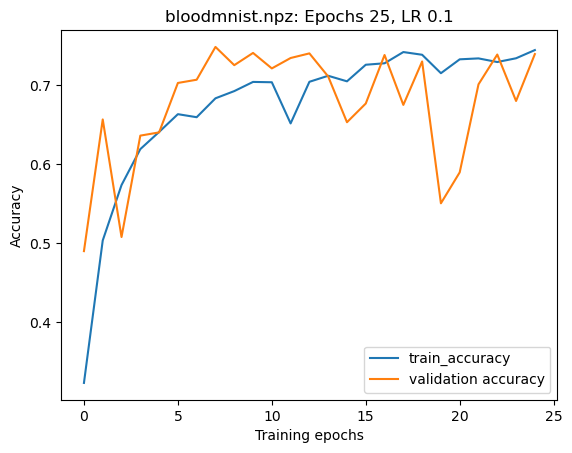

Training time: 9.14 seconds
Evaluation time: 0.11 seconds
Accuracy: 73.955, Loss: 0.72039, Epochs: 25, LR 0.1

Training... bloodmnist.npz: Epochs 50, LR 0.1


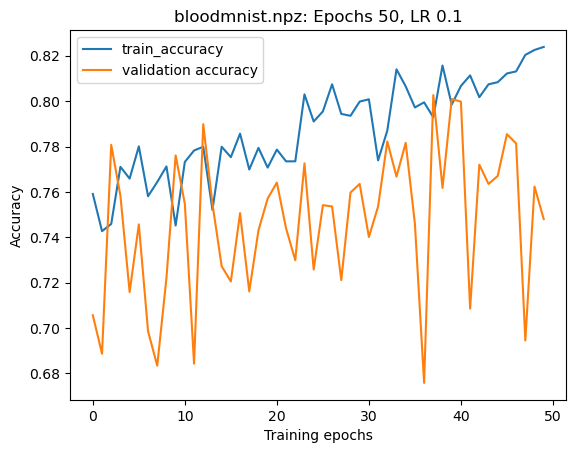

Training time: 16.74 seconds
Evaluation time: 0.1 seconds
Accuracy: 74.803, Loss: 0.71604, Epochs: 50, LR 0.1

Training... bloodmnist.npz: Epochs 100, LR 0.1


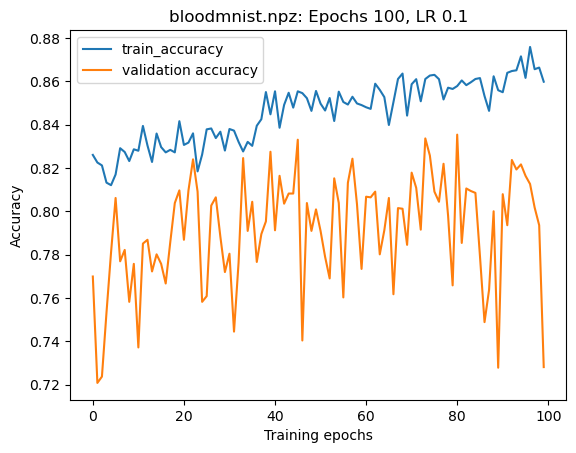

Training time: 33.67 seconds
Evaluation time: 0.11 seconds
Accuracy: 72.815, Loss: 0.86646, Epochs: 100, LR 0.1

Training... bloodmnist.npz: Epochs 150, LR 0.1


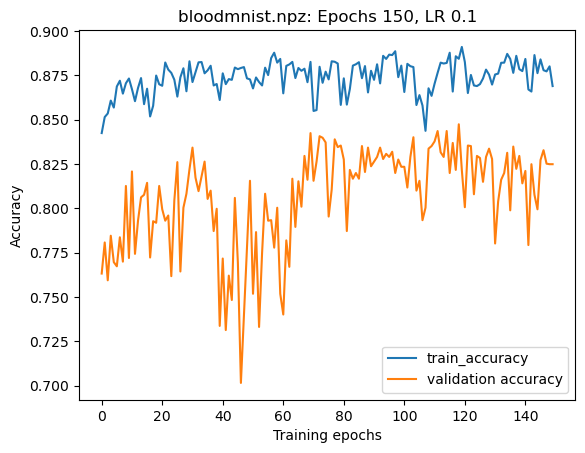

Training time: 51.08 seconds
Evaluation time: 0.11 seconds
Accuracy: 82.49, Loss: 0.57898, Epochs: 150, LR 0.1


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 2352)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         301,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 314,120 (1.20 MB)

 Trainable params: 314,120 (1.20 MB)

 Non-trainable params: 0 (0.00 B)


Training... bloodmnist.npz: Epochs 25, LR 0.01


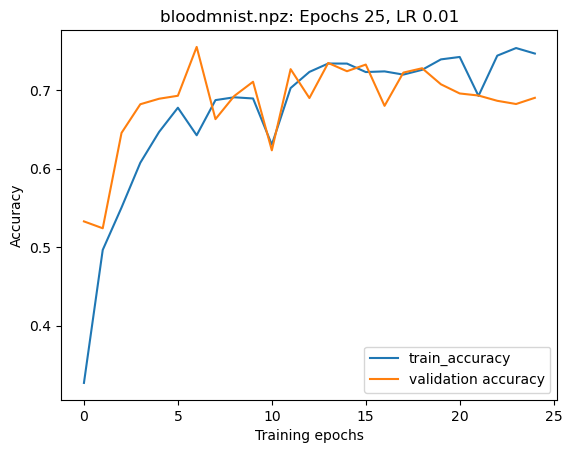

Training time: 9.42 seconds
Evaluation time: 0.11 seconds
Accuracy: 69.044, Loss: 0.86651, Epochs: 25, LR 0.01

Training... bloodmnist.npz: Epochs 50, LR 0.01


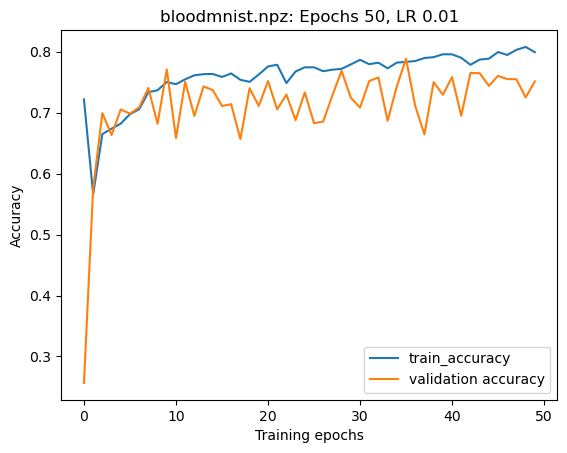

Training time: 17.54 seconds
Evaluation time: 0.1 seconds
Accuracy: 75.124, Loss: 0.66975, Epochs: 50, LR 0.01

Training... bloodmnist.npz: Epochs 100, LR 0.01


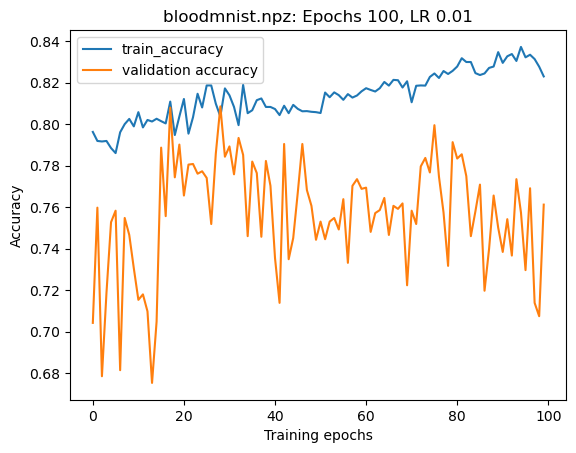

Training time: 35.13 seconds
Evaluation time: 0.11 seconds
Accuracy: 76.118, Loss: 0.68295, Epochs: 100, LR 0.01

Training... bloodmnist.npz: Epochs 150, LR 0.01


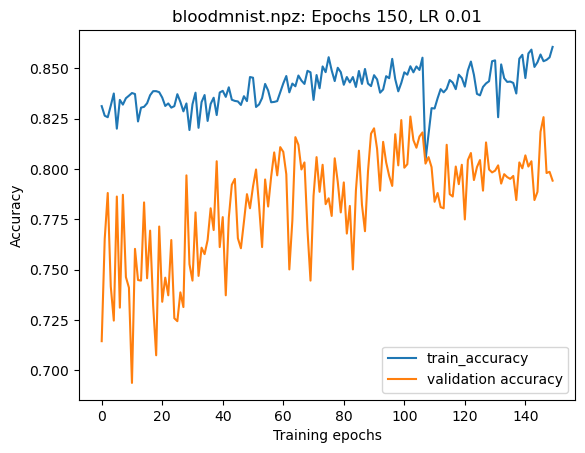

Training time: 52.6 seconds
Evaluation time: 0.11 seconds
Accuracy: 79.421, Loss: 0.61652, Epochs: 150, LR 0.01


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 2352)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         301,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 314,120 (1.20 MB)

 Trainable params: 314,120 (1.20 MB)

 Non-trainable params: 0 (0.00 B)


Training... bloodmnist.npz: Epochs 25, LR 0.001


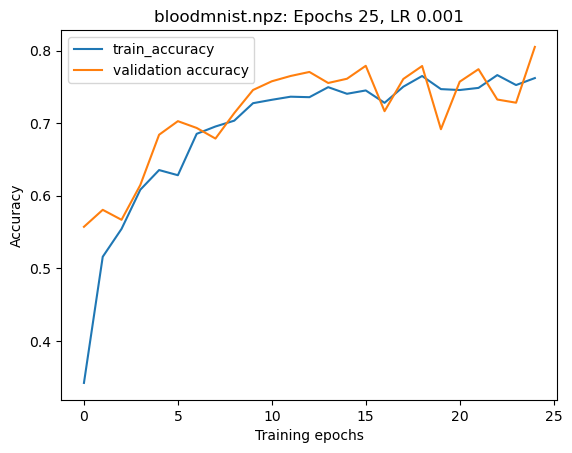

Training time: 9.38 seconds
Evaluation time: 0.12 seconds
Accuracy: 80.503, Loss: 0.5653, Epochs: 25, LR 0.001

Training... bloodmnist.npz: Epochs 50, LR 0.001


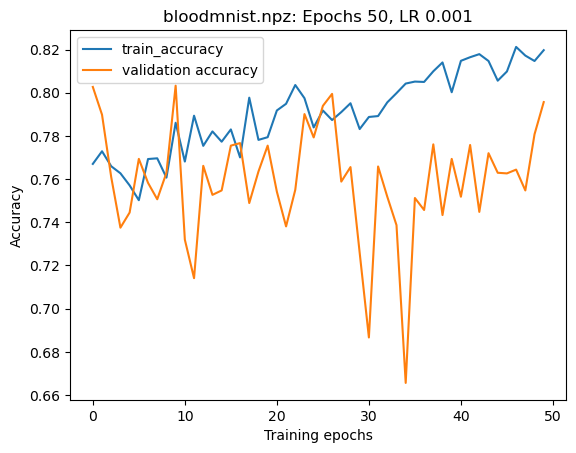

Training time: 17.86 seconds
Evaluation time: 0.1 seconds
Accuracy: 79.567, Loss: 0.53982, Epochs: 50, LR 0.001

Training... bloodmnist.npz: Epochs 100, LR 0.001


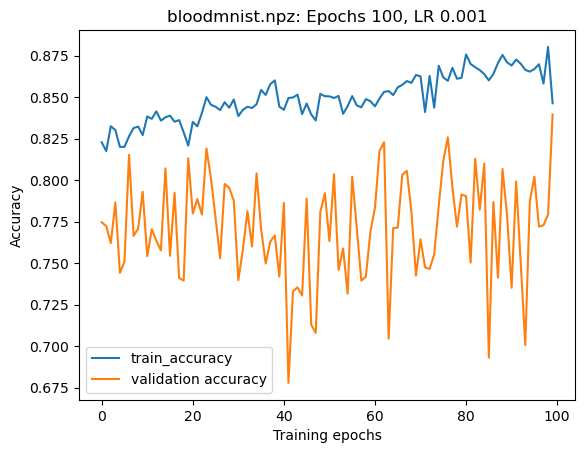

Training time: 36.07 seconds
Evaluation time: 0.11 seconds
Accuracy: 83.952, Loss: 0.47366, Epochs: 100, LR 0.001

Training... bloodmnist.npz: Epochs 150, LR 0.001


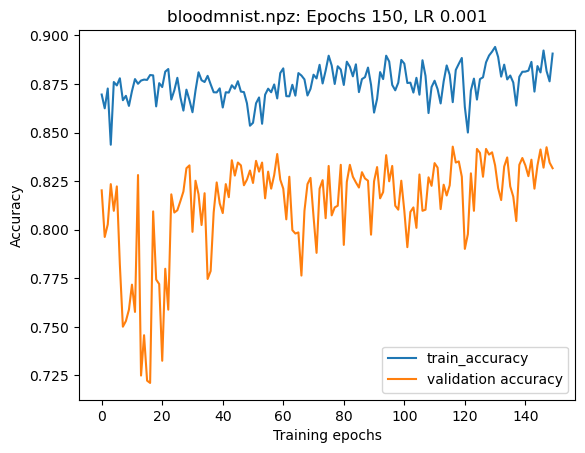

Training time: 53.16 seconds
Evaluation time: 0.1 seconds
Accuracy: 83.163, Loss: 0.54364, Epochs: 150, LR 0.001

-------------------------------------------------------
breastmnist.npz
  train_images: 546 2D images: 28x28
  val_images: 78 2D images: 28x28
  test_images: 156 2D images: 28x28

Label:  1


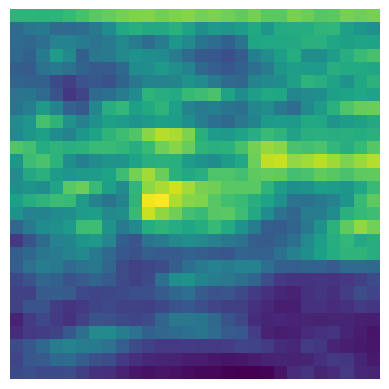

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 113,026 (441.51 KB)

 Trainable params: 113,026 (441.51 KB)

 Non-trainable params: 0 (0.00 B)


Training... breastmnist.npz: Epochs 25, LR 0.1


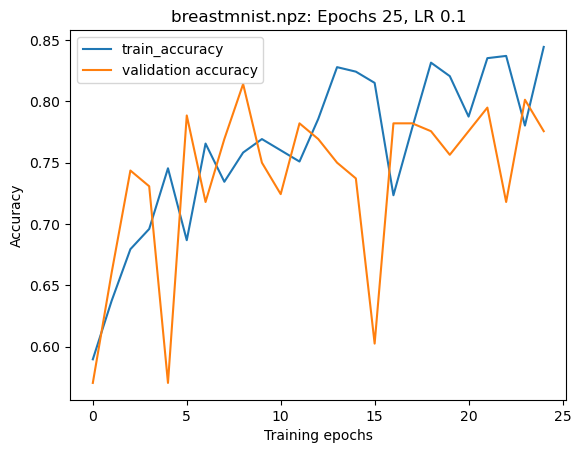

Training time: 1.87 seconds
Evaluation time: 0.04 seconds
Accuracy: 77.564, Loss: 1.18961, Epochs: 25, LR 0.1

Training... breastmnist.npz: Epochs 50, LR 0.1


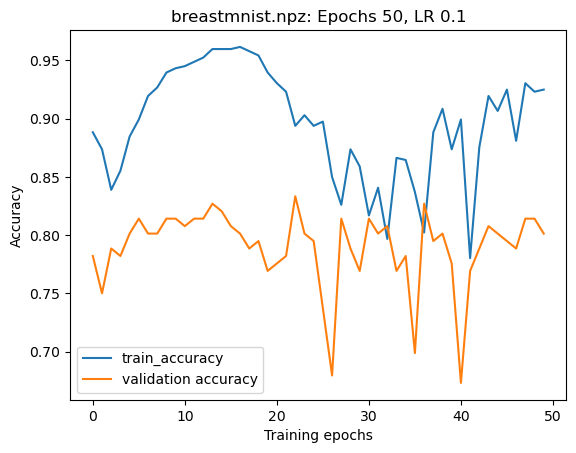

Training time: 2.73 seconds
Evaluation time: 0.04 seconds
Accuracy: 80.128, Loss: 0.83516, Epochs: 50, LR 0.1

Training... breastmnist.npz: Epochs 100, LR 0.1


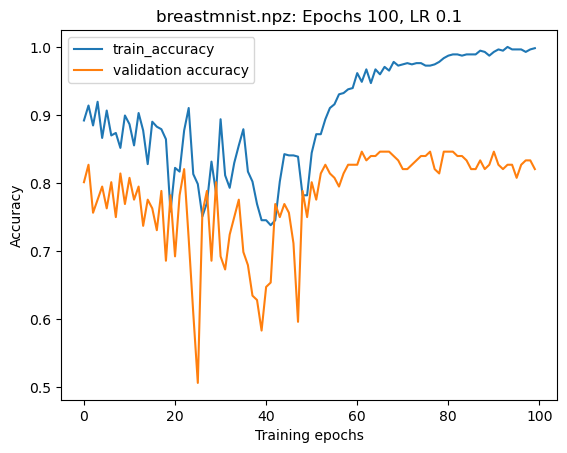

Training time: 5.36 seconds
Evaluation time: 0.04 seconds
Accuracy: 82.051, Loss: 1.05795, Epochs: 100, LR 0.1

Training... breastmnist.npz: Epochs 150, LR 0.1


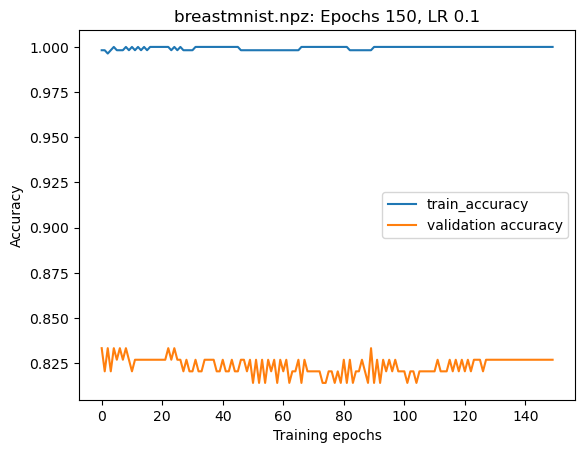

Training time: 8.06 seconds
Evaluation time: 0.06 seconds
Accuracy: 82.692, Loss: 1.63701, Epochs: 150, LR 0.1


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 113,026 (441.51 KB)

 Trainable params: 113,026 (441.51 KB)

 Non-trainable params: 0 (0.00 B)


Training... breastmnist.npz: Epochs 25, LR 0.01


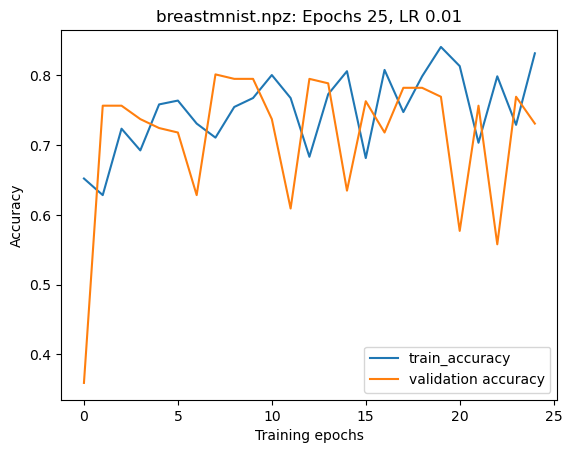

Training time: 1.97 seconds
Evaluation time: 0.04 seconds
Accuracy: 73.077, Loss: 1.93608, Epochs: 25, LR 0.01

Training... breastmnist.npz: Epochs 50, LR 0.01


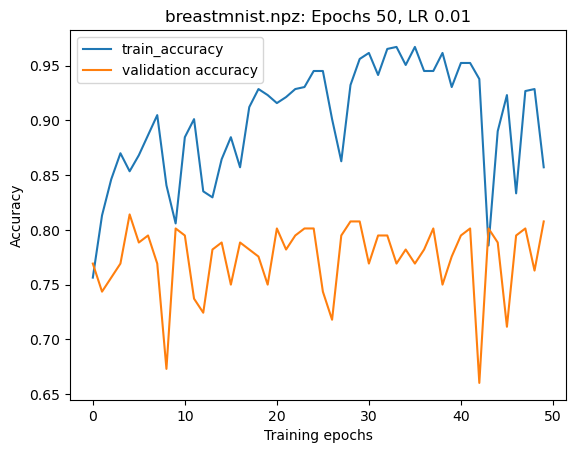

Training time: 2.66 seconds
Evaluation time: 0.1 seconds
Accuracy: 80.769, Loss: 2.092, Epochs: 50, LR 0.01

Training... breastmnist.npz: Epochs 100, LR 0.01


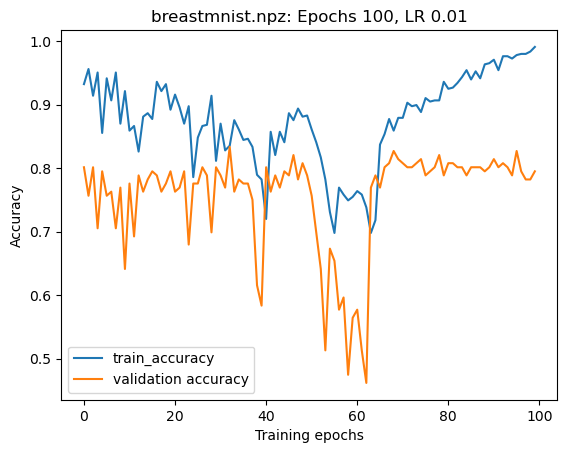

Training time: 5.44 seconds
Evaluation time: 0.04 seconds
Accuracy: 79.487, Loss: 1.48855, Epochs: 100, LR 0.01

Training... breastmnist.npz: Epochs 150, LR 0.01


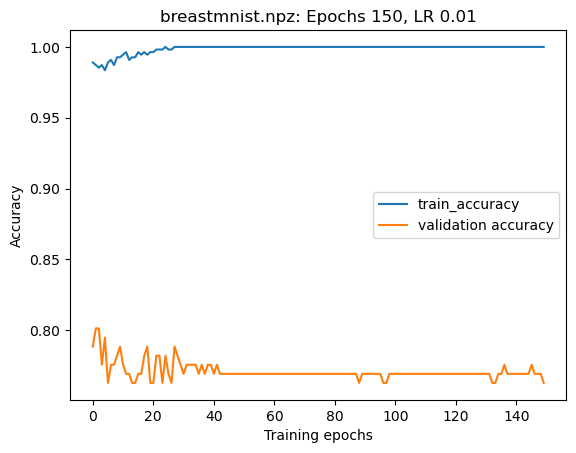

Training time: 7.9 seconds
Evaluation time: 0.04 seconds
Accuracy: 76.282, Loss: 3.44124, Epochs: 150, LR 0.01


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 113,026 (441.51 KB)

 Trainable params: 113,026 (441.51 KB)

 Non-trainable params: 0 (0.00 B)


Training... breastmnist.npz: Epochs 25, LR 0.001


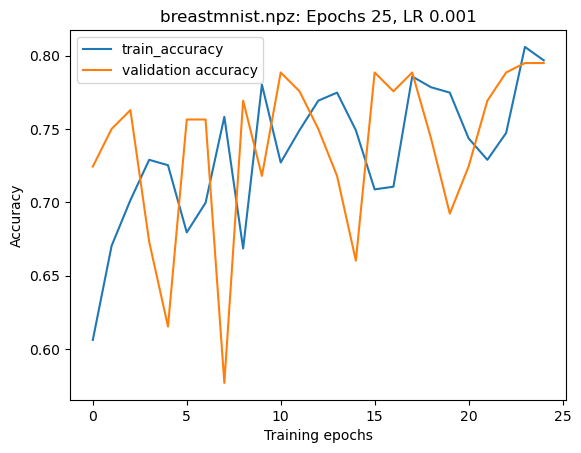

Training time: 2.0 seconds
Evaluation time: 0.04 seconds
Accuracy: 79.487, Loss: 0.60381, Epochs: 25, LR 0.001

Training... breastmnist.npz: Epochs 50, LR 0.001


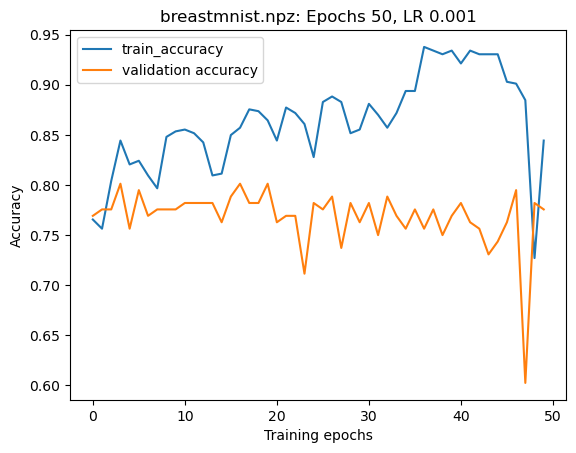

Training time: 2.74 seconds
Evaluation time: 0.04 seconds
Accuracy: 77.564, Loss: 1.65434, Epochs: 50, LR 0.001

Training... breastmnist.npz: Epochs 100, LR 0.001


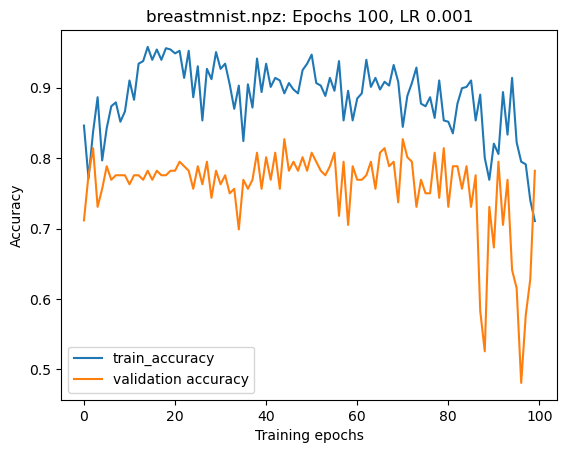

Training time: 5.36 seconds
Evaluation time: 0.04 seconds
Accuracy: 78.205, Loss: 0.98814, Epochs: 100, LR 0.001

Training... breastmnist.npz: Epochs 150, LR 0.001


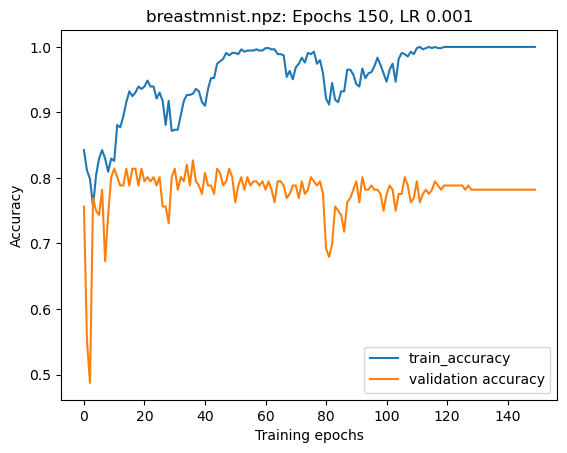

Training time: 7.89 seconds
Evaluation time: 0.1 seconds
Accuracy: 78.205, Loss: 1.59815, Epochs: 150, LR 0.001

-------------------------------------------------------
dermamnist.npz
  train_images: 7007 RGB images:28x28x3
  val_images: 1003 RGB images:28x28x3
  test_images: 2005 RGB images:28x28x3

Label:  0


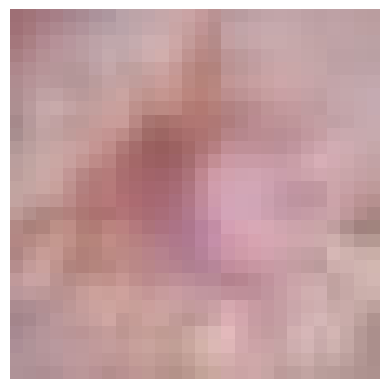

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 2352)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         301,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 314,055 (1.20 MB)

 Trainable params: 314,055 (1.20 MB)

 Non-trainable params: 0 (0.00 B)


Training... dermamnist.npz: Epochs 25, LR 0.1


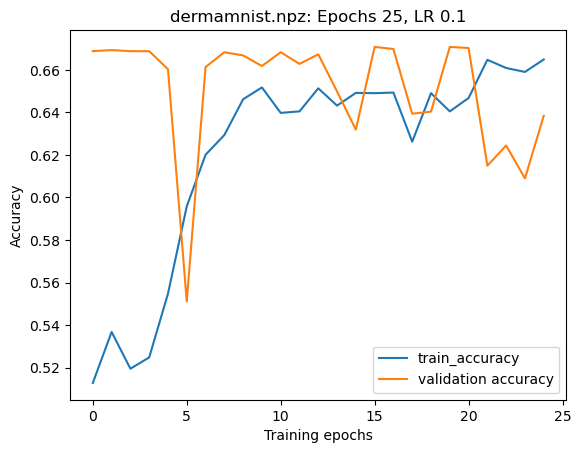

Training time: 6.11 seconds
Evaluation time: 0.08 seconds
Accuracy: 63.84, Loss: 1.09648, Epochs: 25, LR 0.1

Training... dermamnist.npz: Epochs 50, LR 0.1


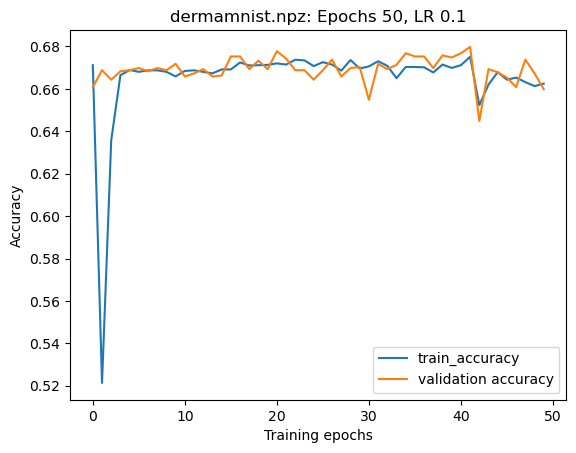

Training time: 11.19 seconds
Evaluation time: 0.08 seconds
Accuracy: 65.985, Loss: 0.92977, Epochs: 50, LR 0.1

Training... dermamnist.npz: Epochs 100, LR 0.1


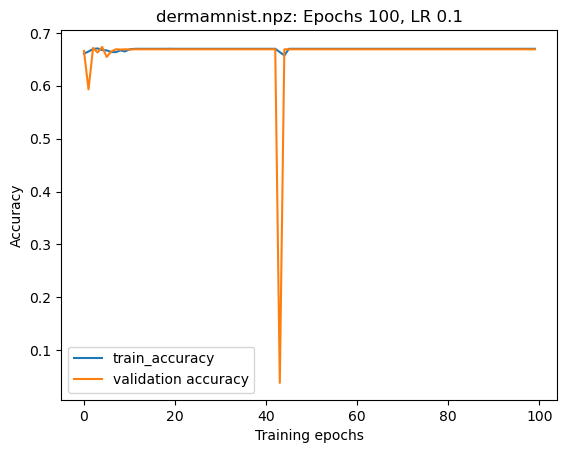

Training time: 22.26 seconds
Evaluation time: 0.11 seconds
Accuracy: 66.883, Loss: 1.13325, Epochs: 100, LR 0.1

Training... dermamnist.npz: Epochs 150, LR 0.1


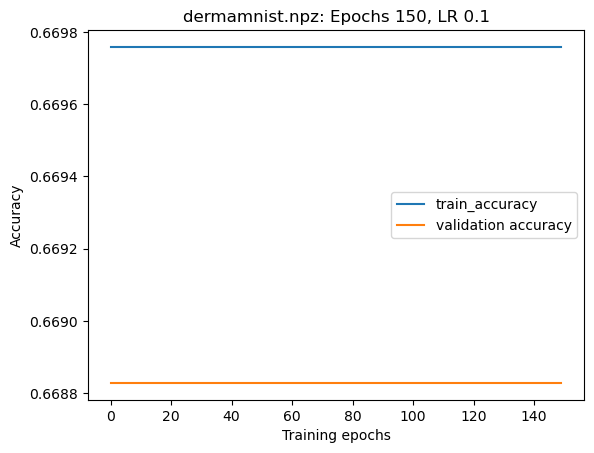

Training time: 33.29 seconds
Evaluation time: 0.08 seconds
Accuracy: 66.883, Loss: 1.13325, Epochs: 150, LR 0.1


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 2352)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         301,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 314,055 (1.20 MB)

 Trainable params: 314,055 (1.20 MB)

 Non-trainable params: 0 (0.00 B)


Training... dermamnist.npz: Epochs 25, LR 0.01


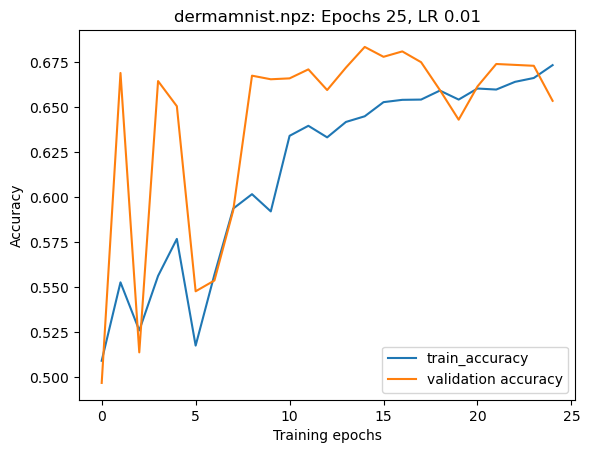

Training time: 6.15 seconds
Evaluation time: 0.12 seconds
Accuracy: 65.337, Loss: 1.08512, Epochs: 25, LR 0.01

Training... dermamnist.npz: Epochs 50, LR 0.01


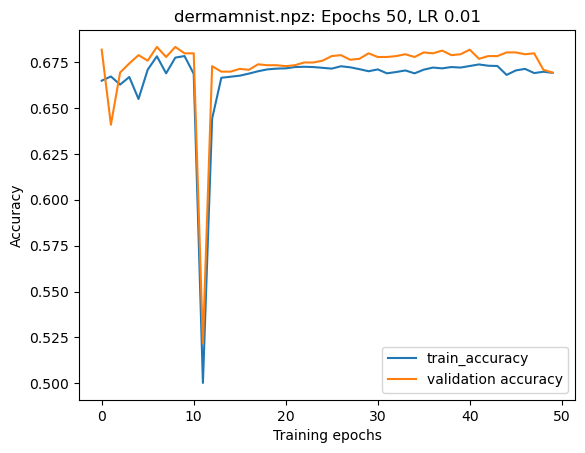

Training time: 11.19 seconds
Evaluation time: 0.08 seconds
Accuracy: 66.933, Loss: 0.91421, Epochs: 50, LR 0.01

Training... dermamnist.npz: Epochs 100, LR 0.01


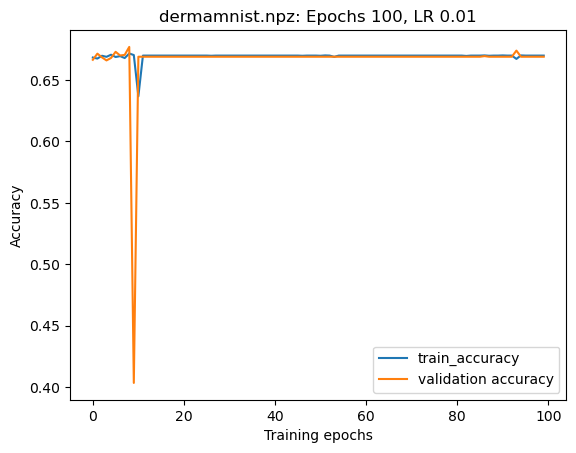

Training time: 22.04 seconds
Evaluation time: 0.08 seconds
Accuracy: 66.883, Loss: 0.93207, Epochs: 100, LR 0.01

Training... dermamnist.npz: Epochs 150, LR 0.01


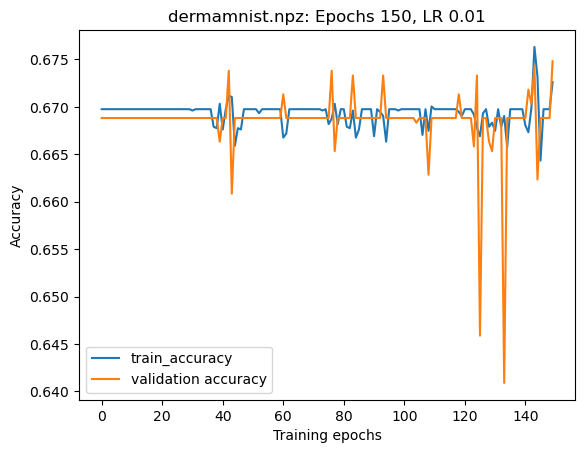

Training time: 34.28 seconds
Evaluation time: 0.13 seconds
Accuracy: 67.481, Loss: 0.94901, Epochs: 150, LR 0.01


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 2352)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         301,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 314,055 (1.20 MB)

 Trainable params: 314,055 (1.20 MB)

 Non-trainable params: 0 (0.00 B)


Training... dermamnist.npz: Epochs 25, LR 0.001


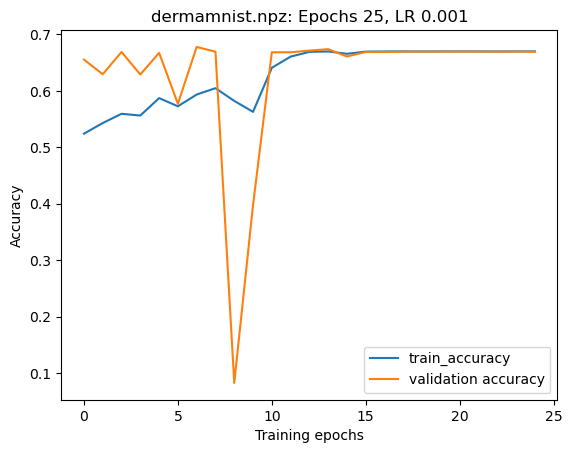

Training time: 6.12 seconds
Evaluation time: 0.08 seconds
Accuracy: 66.933, Loss: 0.95369, Epochs: 25, LR 0.001

Training... dermamnist.npz: Epochs 50, LR 0.001


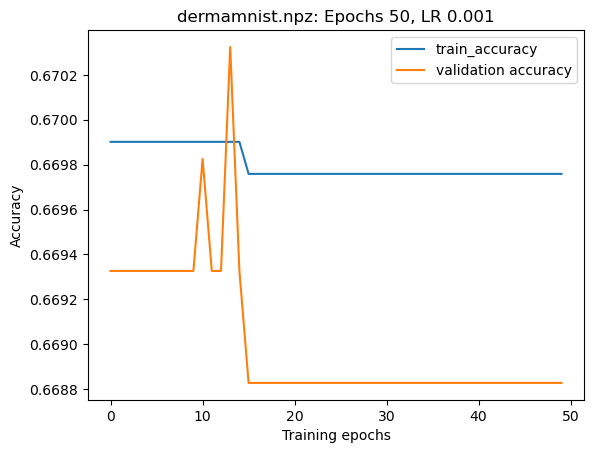

Training time: 12.52 seconds
Evaluation time: 0.08 seconds
Accuracy: 66.883, Loss: 1.01563, Epochs: 50, LR 0.001

Training... dermamnist.npz: Epochs 100, LR 0.001


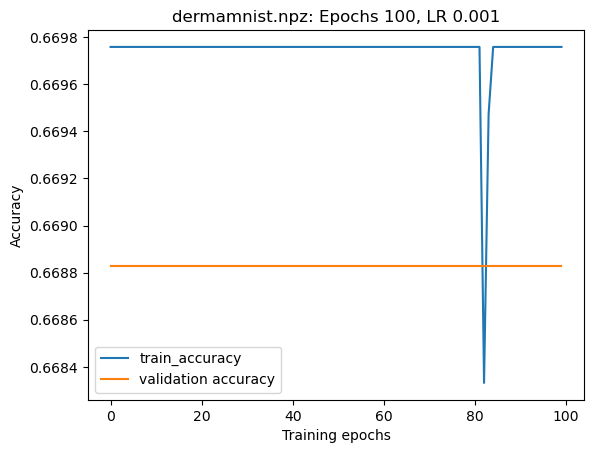

Training time: 22.01 seconds
Evaluation time: 0.08 seconds
Accuracy: 66.883, Loss: 0.94905, Epochs: 100, LR 0.001

Training... dermamnist.npz: Epochs 150, LR 0.001


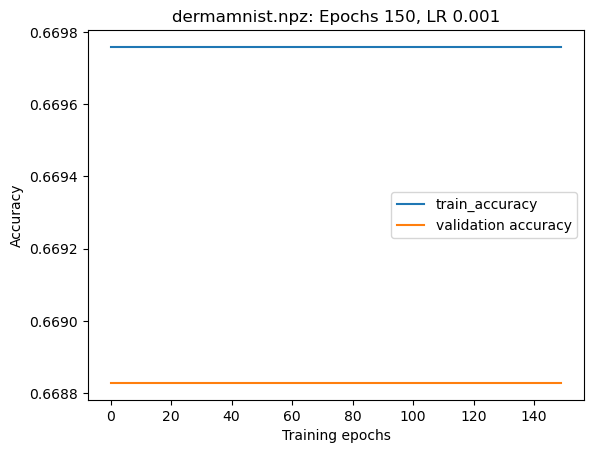

Training time: 33.02 seconds
Evaluation time: 0.09 seconds
Accuracy: 66.883, Loss: 1.13684, Epochs: 150, LR 0.001

-------------------------------------------------------
octmnist.npz
  train_images: 97477 2D images: 28x28
  val_images: 10832 2D images: 28x28
  test_images: 1000 2D images: 28x28

Label:  0


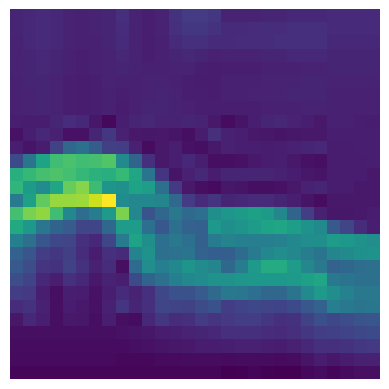

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 113,156 (442.02 KB)

 Trainable params: 113,156 (442.02 KB)

 Non-trainable params: 0 (0.00 B)


Training... octmnist.npz: Epochs 25, LR 0.1


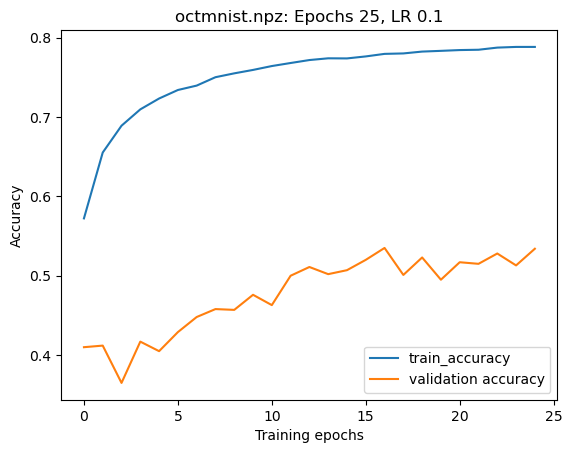

Training time: 35.3 seconds
Evaluation time: 0.05 seconds
Accuracy: 53.4, Loss: 1.19829, Epochs: 25, LR 0.1

Training... octmnist.npz: Epochs 50, LR 0.1


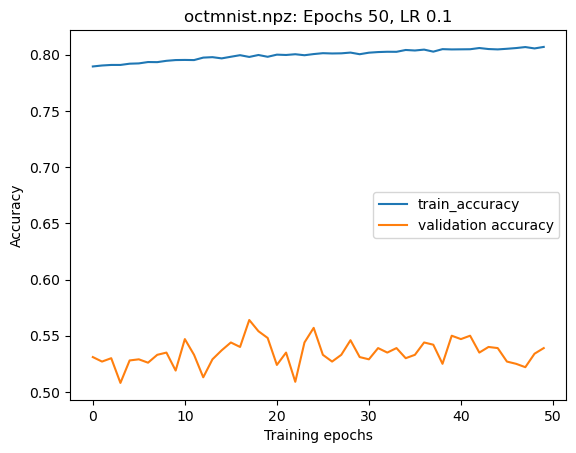

Training time: 69.33 seconds
Evaluation time: 0.05 seconds
Accuracy: 53.9, Loss: 1.23757, Epochs: 50, LR 0.1

Training... octmnist.npz: Epochs 100, LR 0.1


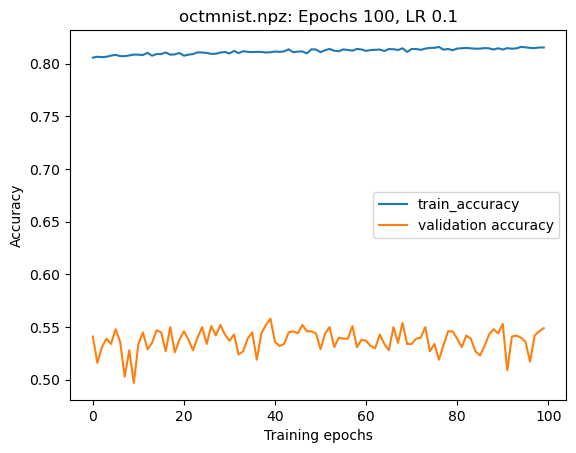

Training time: 138.13 seconds
Evaluation time: 0.05 seconds
Accuracy: 54.9, Loss: 1.24675, Epochs: 100, LR 0.1

Training... octmnist.npz: Epochs 150, LR 0.1


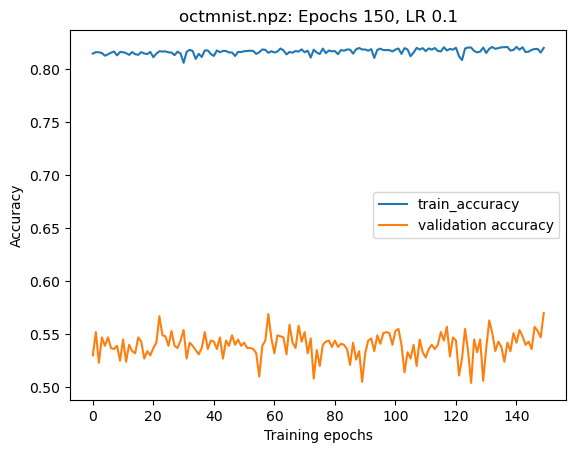

Training time: 206.79 seconds
Evaluation time: 0.06 seconds
Accuracy: 57.0, Loss: 1.27809, Epochs: 150, LR 0.1


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 113,156 (442.02 KB)

 Trainable params: 113,156 (442.02 KB)

 Non-trainable params: 0 (0.00 B)


Training... octmnist.npz: Epochs 25, LR 0.01


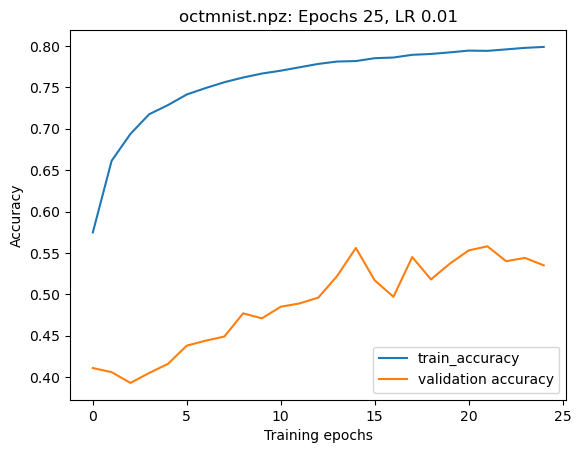

Training time: 35.66 seconds
Evaluation time: 0.06 seconds
Accuracy: 53.5, Loss: 1.17349, Epochs: 25, LR 0.01

Training... octmnist.npz: Epochs 50, LR 0.01


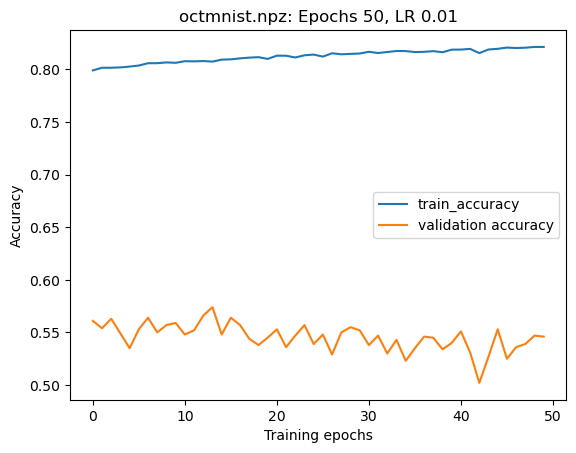

Training time: 72.34 seconds
Evaluation time: 0.05 seconds
Accuracy: 54.6, Loss: 1.29934, Epochs: 50, LR 0.01

Training... octmnist.npz: Epochs 100, LR 0.01


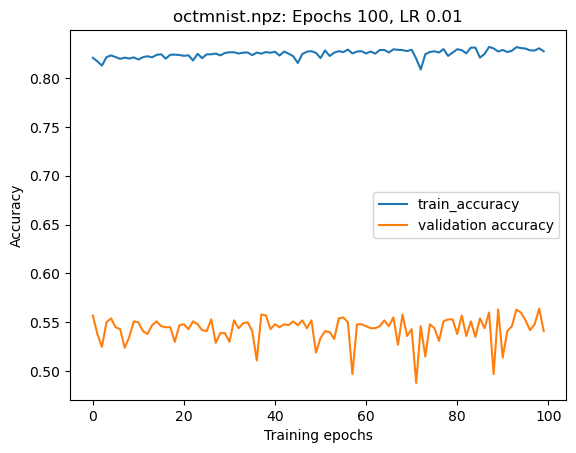

Training time: 141.74 seconds
Evaluation time: 0.05 seconds
Accuracy: 54.1, Loss: 1.39644, Epochs: 100, LR 0.01

Training... octmnist.npz: Epochs 150, LR 0.01


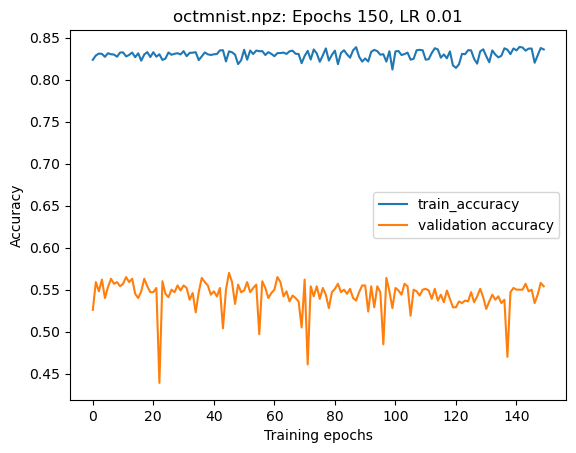

Training time: 211.32 seconds
Evaluation time: 0.06 seconds
Accuracy: 55.4, Loss: 14.51006, Epochs: 150, LR 0.01


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 113,156 (442.02 KB)

 Trainable params: 113,156 (442.02 KB)

 Non-trainable params: 0 (0.00 B)


Training... octmnist.npz: Epochs 25, LR 0.001


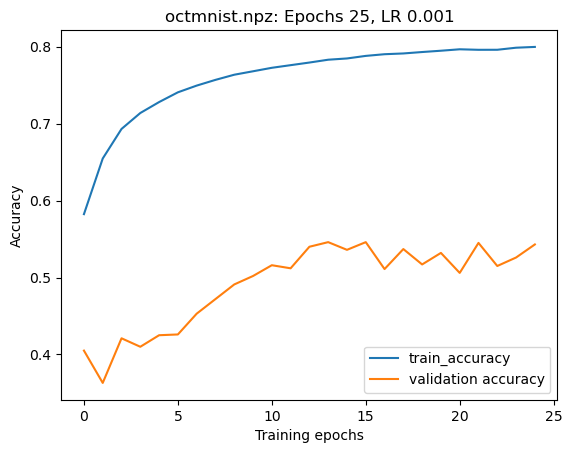

Training time: 35.24 seconds
Evaluation time: 0.05 seconds
Accuracy: 54.3, Loss: 1.14902, Epochs: 25, LR 0.001

Training... octmnist.npz: Epochs 50, LR 0.001


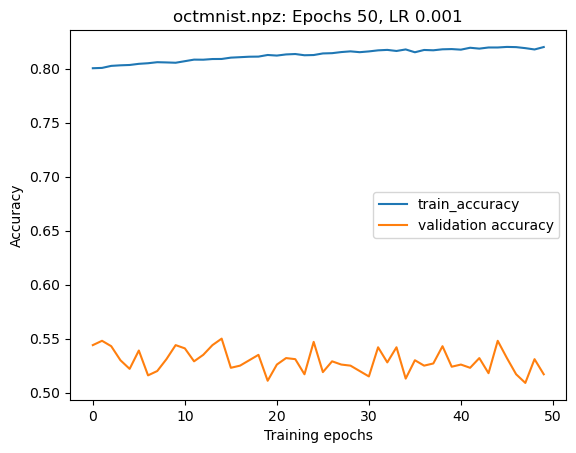

Training time: 69.55 seconds
Evaluation time: 0.05 seconds
Accuracy: 51.7, Loss: 1.24341, Epochs: 50, LR 0.001

Training... octmnist.npz: Epochs 100, LR 0.001


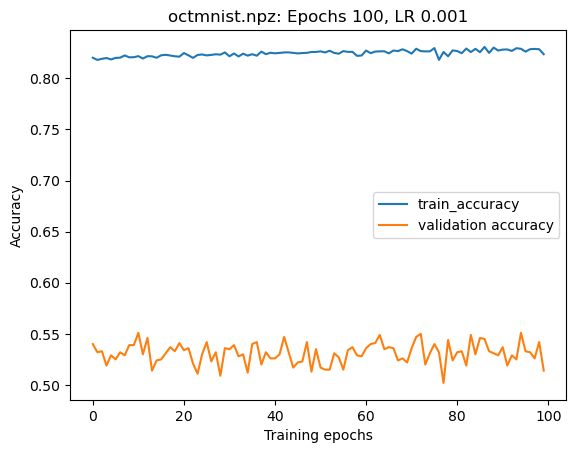

Training time: 139.44 seconds
Evaluation time: 0.05 seconds
Accuracy: 51.4, Loss: 1.28255, Epochs: 100, LR 0.001

Training... octmnist.npz: Epochs 150, LR 0.001


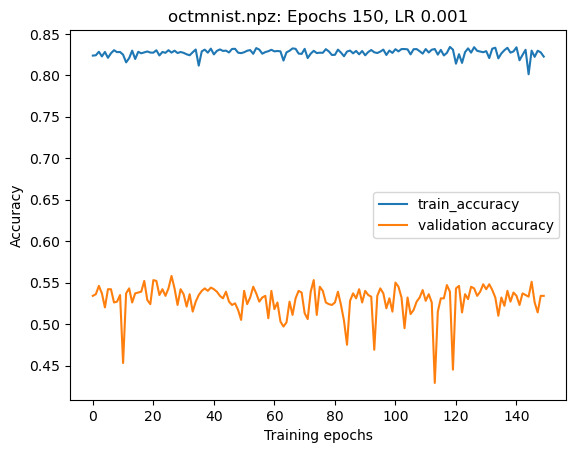

Training time: 271.0 seconds
Evaluation time: 0.06 seconds
Accuracy: 53.4, Loss: 1.23824, Epochs: 150, LR 0.001

-------------------------------------------------------
organsmnist.npz
  train_images: 13932 2D images: 28x28
  val_images: 2452 2D images: 28x28
  test_images: 8827 2D images: 28x28

Label:  8


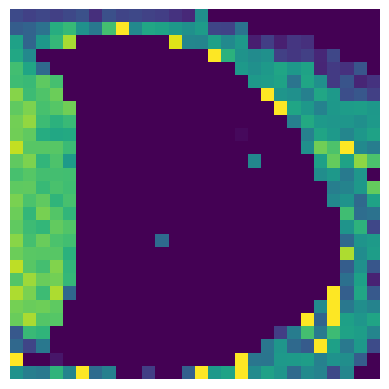

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 11)                  │             715 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 113,611 (443.79 KB)

 Trainable params: 113,611 (443.79 KB)

 Non-trainable params: 0 (0.00 B)


Training... organsmnist.npz: Epochs 25, LR 0.1


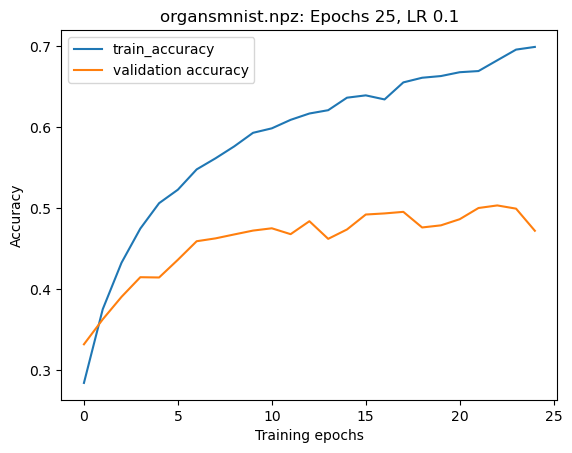

Training time: 8.43 seconds
Evaluation time: 0.17 seconds
Accuracy: 47.219, Loss: 1.85432, Epochs: 25, LR 0.1

Training... organsmnist.npz: Epochs 50, LR 0.1


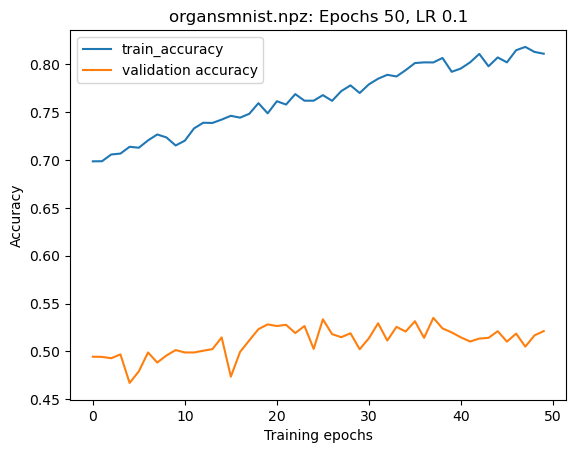

Training time: 15.77 seconds
Evaluation time: 0.18 seconds
Accuracy: 52.124, Loss: 2.55459, Epochs: 50, LR 0.1

Training... organsmnist.npz: Epochs 100, LR 0.1


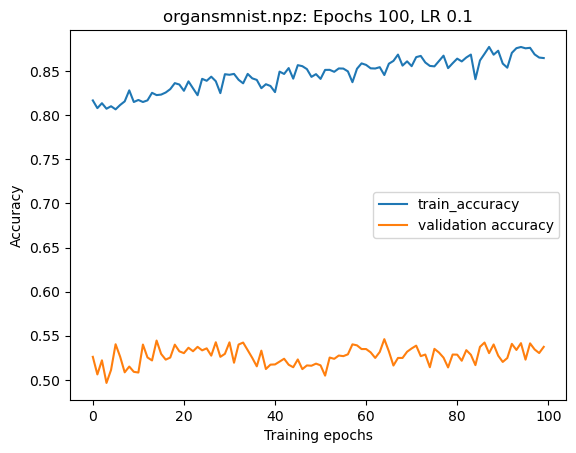

Training time: 32.67 seconds
Evaluation time: 0.18 seconds
Accuracy: 53.744, Loss: 4.11852, Epochs: 100, LR 0.1

Training... organsmnist.npz: Epochs 150, LR 0.1


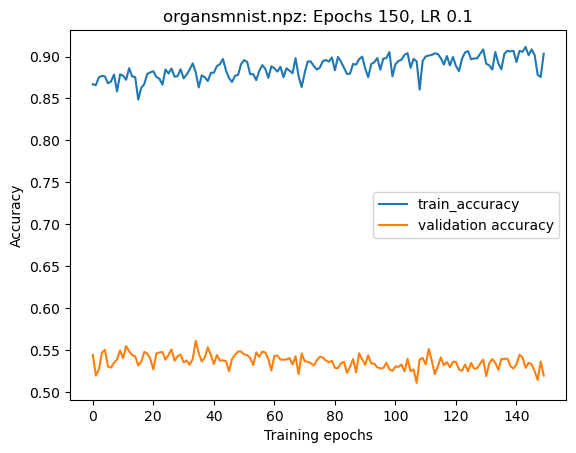

Training time: 47.37 seconds
Evaluation time: 0.21 seconds
Accuracy: 51.977, Loss: 5.89999, Epochs: 150, LR 0.1


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 11)                  │             715 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 113,611 (443.79 KB)

 Trainable params: 113,611 (443.79 KB)

 Non-trainable params: 0 (0.00 B)


Training... organsmnist.npz: Epochs 25, LR 0.01


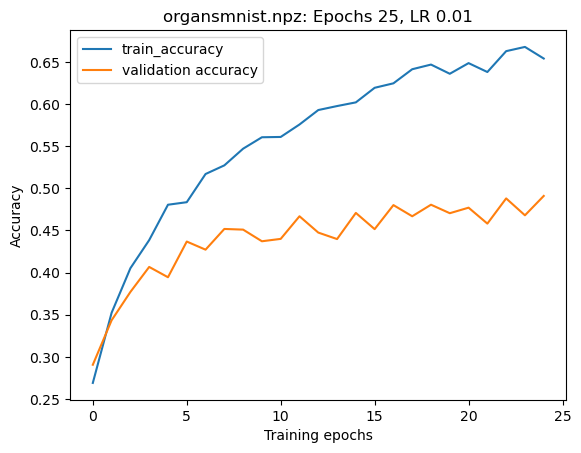

Training time: 8.43 seconds
Evaluation time: 0.18 seconds
Accuracy: 49.099, Loss: 1.80279, Epochs: 25, LR 0.01

Training... organsmnist.npz: Epochs 50, LR 0.01


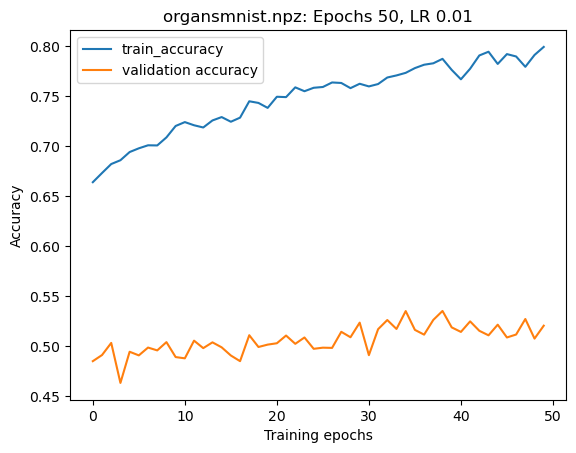

Training time: 15.58 seconds
Evaluation time: 0.21 seconds
Accuracy: 52.022, Loss: 2.62917, Epochs: 50, LR 0.01

Training... organsmnist.npz: Epochs 100, LR 0.01


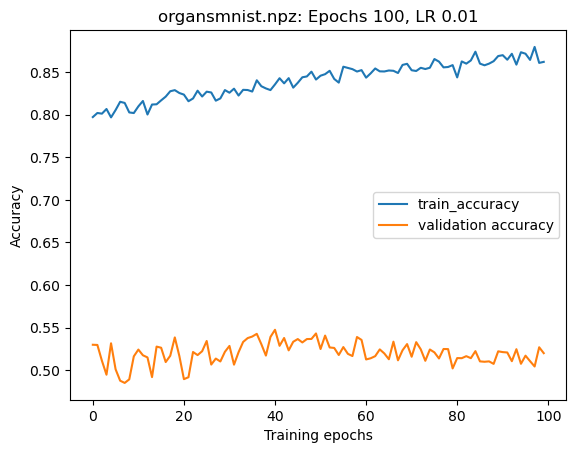

Training time: 31.56 seconds
Evaluation time: 0.23 seconds
Accuracy: 52.022, Loss: 5.03105, Epochs: 100, LR 0.01

Training... organsmnist.npz: Epochs 150, LR 0.01


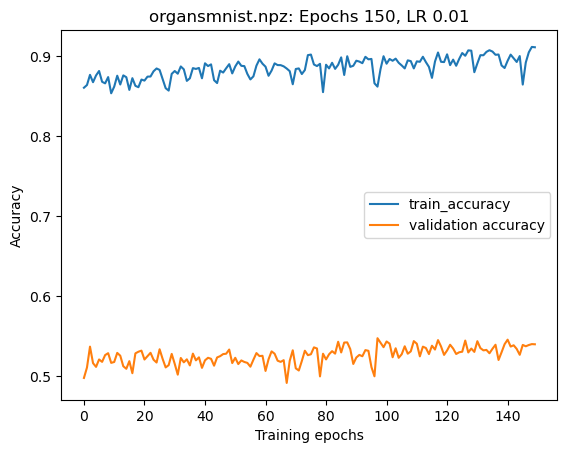

Training time: 47.04 seconds
Evaluation time: 0.23 seconds
Accuracy: 54.005, Loss: 6.68647, Epochs: 150, LR 0.01


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 11)                  │             715 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 113,611 (443.79 KB)

 Trainable params: 113,611 (443.79 KB)

 Non-trainable params: 0 (0.00 B)


Training... organsmnist.npz: Epochs 25, LR 0.001


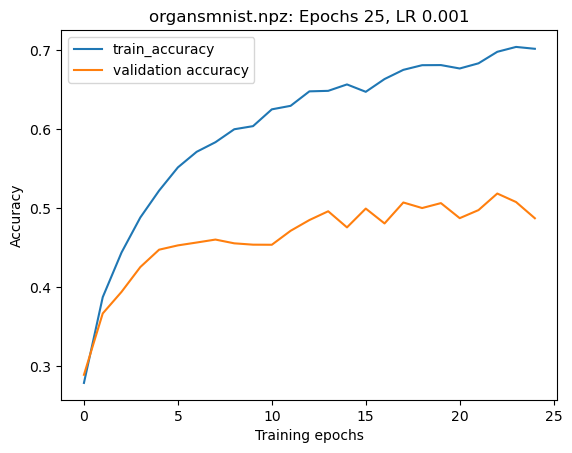

Training time: 8.31 seconds
Evaluation time: 0.18 seconds
Accuracy: 48.714, Loss: 1.94995, Epochs: 25, LR 0.001

Training... organsmnist.npz: Epochs 50, LR 0.001


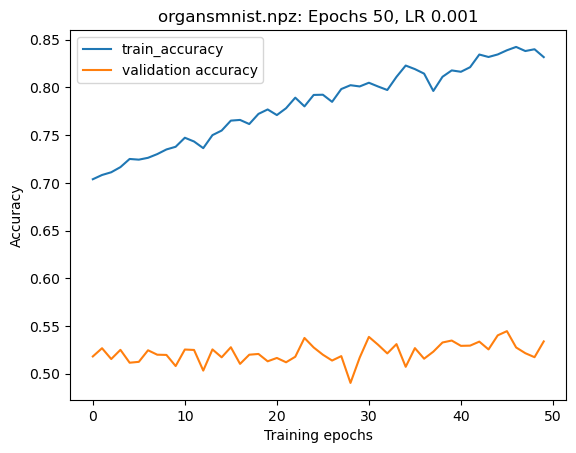

Training time: 15.57 seconds
Evaluation time: 0.18 seconds
Accuracy: 53.382, Loss: 2.70633, Epochs: 50, LR 0.001

Training... organsmnist.npz: Epochs 100, LR 0.001


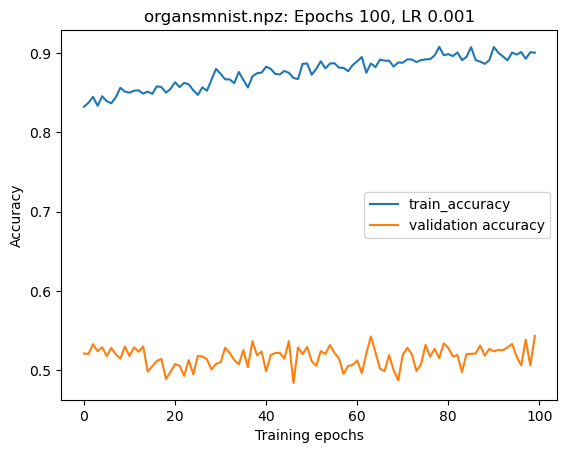

Training time: 31.09 seconds
Evaluation time: 0.25 seconds
Accuracy: 54.322, Loss: 4.68729, Epochs: 100, LR 0.001

Training... organsmnist.npz: Epochs 150, LR 0.001


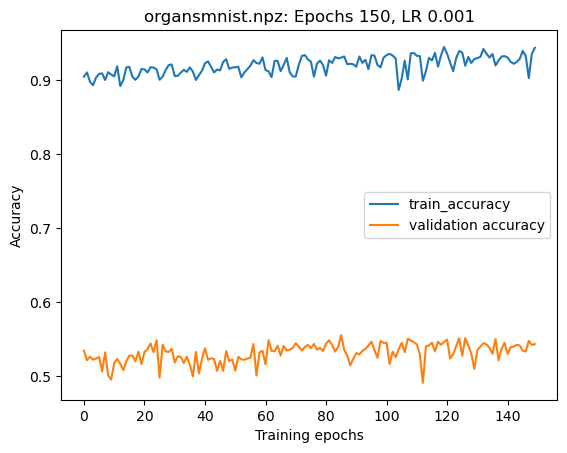

Training time: 46.74 seconds
Evaluation time: 0.18 seconds
Accuracy: 54.356, Loss: 6.88293, Epochs: 150, LR 0.001

-------------------------------------------------------
nodulemnist3d.npz
  train_images: 1158 3D images: 28x28x28
  val_images: 165 3D images: 28x28x28
  test_images: 310 3D images: 28x28x28

Label:  0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 21952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       2,809,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,822,530 (10.77 MB)

 Trainable params: 2,822,530 (10.77 MB)

 Non-trainable params: 0 (0.00 B)


Training... nodulemnist3d.npz: Epochs 25, LR 0.1


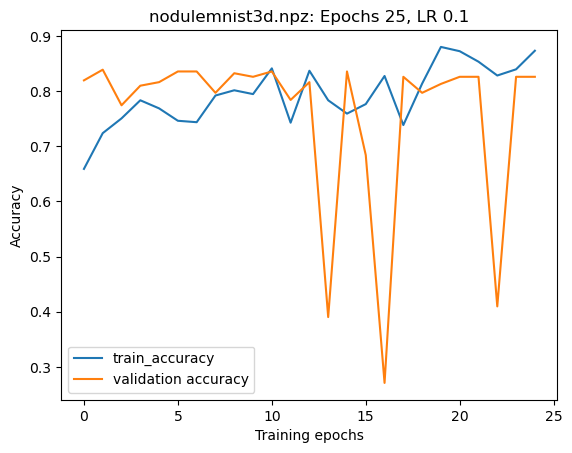

Training time: 4.18 seconds
Evaluation time: 0.05 seconds
Accuracy: 82.581, Loss: 6.51467, Epochs: 25, LR 0.1

Training... nodulemnist3d.npz: Epochs 50, LR 0.1


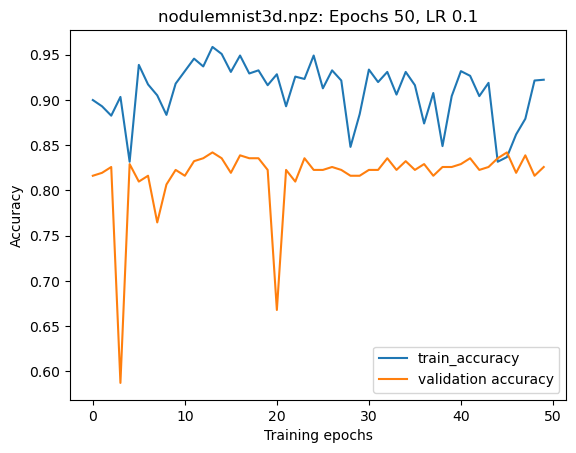

Training time: 7.03 seconds
Evaluation time: 0.05 seconds
Accuracy: 82.581, Loss: 5.115, Epochs: 50, LR 0.1

Training... nodulemnist3d.npz: Epochs 100, LR 0.1


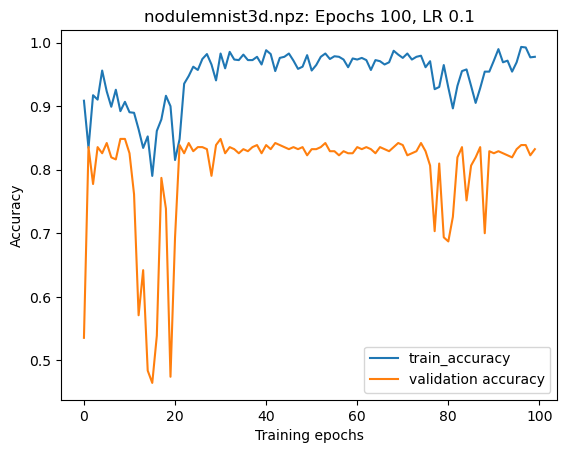

Training time: 14.07 seconds
Evaluation time: 0.05 seconds
Accuracy: 83.226, Loss: 4.75877, Epochs: 100, LR 0.1

Training... nodulemnist3d.npz: Epochs 150, LR 0.1


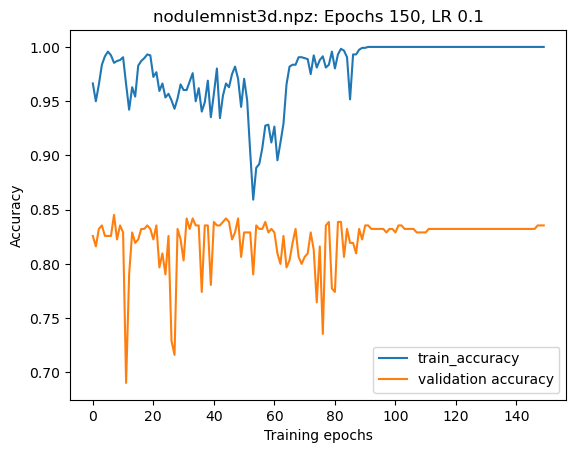

Training time: 21.17 seconds
Evaluation time: 0.05 seconds
Accuracy: 83.548, Loss: 5.30038, Epochs: 150, LR 0.1


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 21952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       2,809,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,822,530 (10.77 MB)

 Trainable params: 2,822,530 (10.77 MB)

 Non-trainable params: 0 (0.00 B)


Training... nodulemnist3d.npz: Epochs 25, LR 0.01


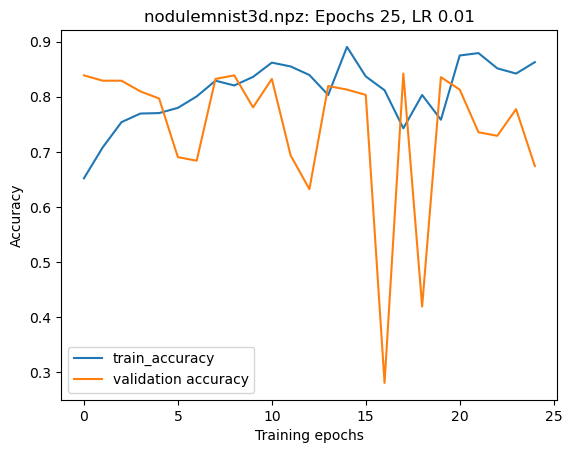

Training time: 4.23 seconds
Evaluation time: 0.05 seconds
Accuracy: 67.419, Loss: 13.68248, Epochs: 25, LR 0.01

Training... nodulemnist3d.npz: Epochs 50, LR 0.01


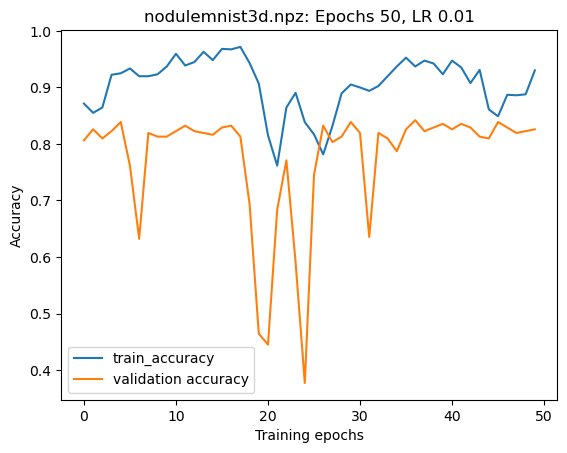

Training time: 7.01 seconds
Evaluation time: 0.05 seconds
Accuracy: 82.581, Loss: 7.86289, Epochs: 50, LR 0.01

Training... nodulemnist3d.npz: Epochs 100, LR 0.01


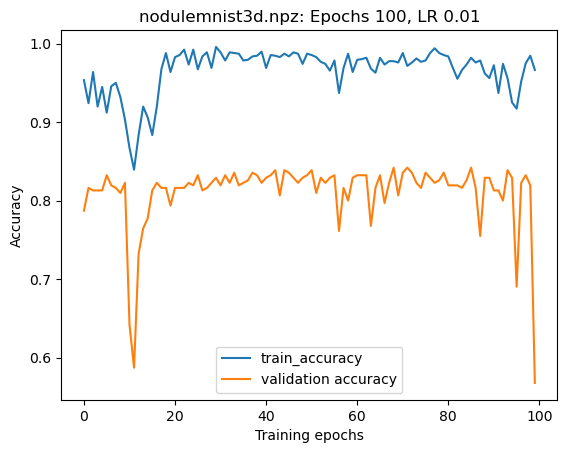

Training time: 14.03 seconds
Evaluation time: 0.05 seconds
Accuracy: 56.774, Loss: 10.28313, Epochs: 100, LR 0.01

Training... nodulemnist3d.npz: Epochs 150, LR 0.01


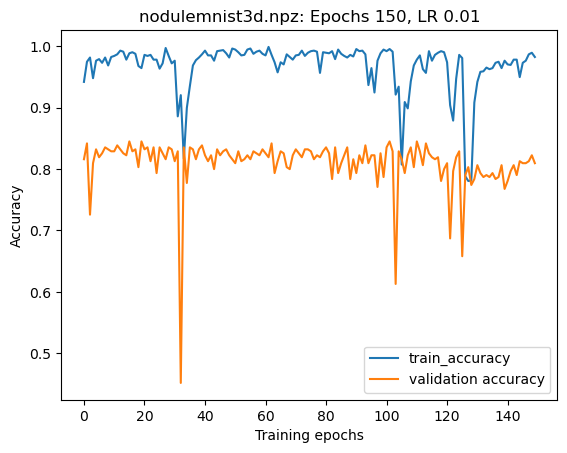

Training time: 21.01 seconds
Evaluation time: 0.07 seconds
Accuracy: 80.968, Loss: 1.14928, Epochs: 150, LR 0.01


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 21952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       2,809,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,822,530 (10.77 MB)

 Trainable params: 2,822,530 (10.77 MB)

 Non-trainable params: 0 (0.00 B)


Training... nodulemnist3d.npz: Epochs 25, LR 0.001


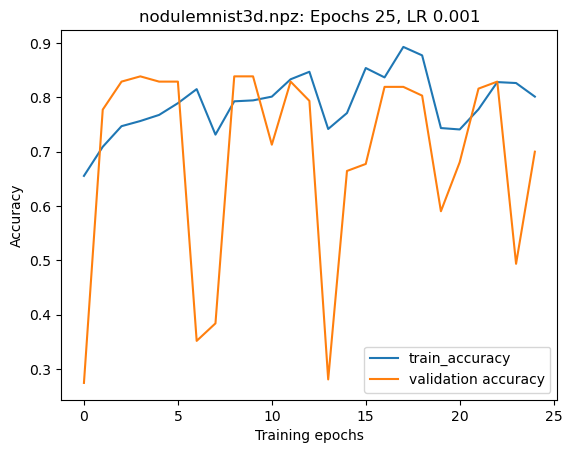

Training time: 4.13 seconds
Evaluation time: 0.05 seconds
Accuracy: 70.0, Loss: 10.85298, Epochs: 25, LR 0.001

Training... nodulemnist3d.npz: Epochs 50, LR 0.001


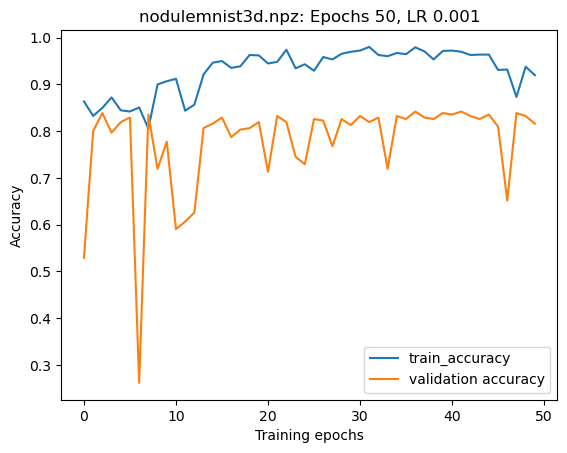

Training time: 7.06 seconds
Evaluation time: 0.09 seconds
Accuracy: 81.613, Loss: 4.11813, Epochs: 50, LR 0.001

Training... nodulemnist3d.npz: Epochs 100, LR 0.001


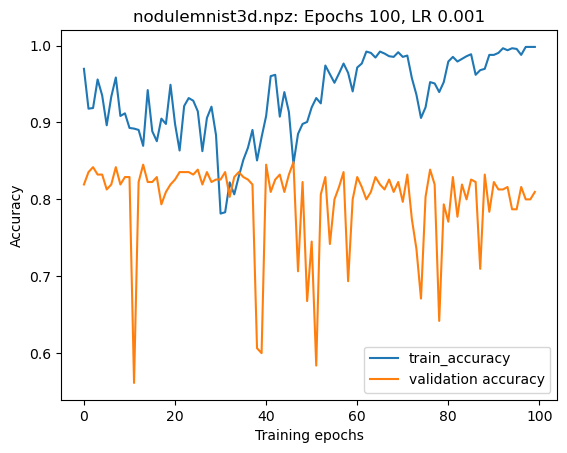

Training time: 14.05 seconds
Evaluation time: 0.05 seconds
Accuracy: 80.968, Loss: 5.12201, Epochs: 100, LR 0.001

Training... nodulemnist3d.npz: Epochs 150, LR 0.001


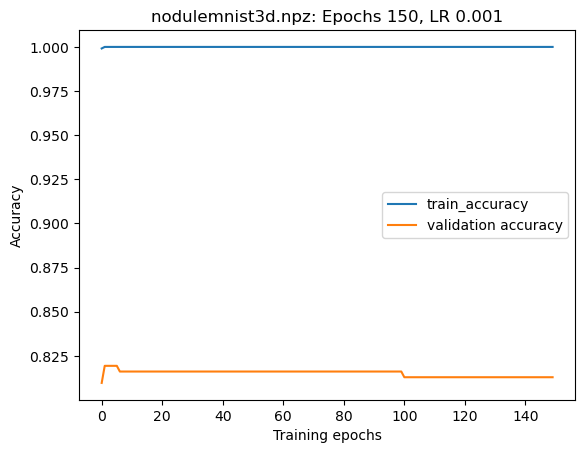

Training time: 20.81 seconds
Evaluation time: 0.05 seconds
Accuracy: 81.29, Loss: 5.16549, Epochs: 150, LR 0.001

-------------------------------------------------------
organmnist3d.npz
  train_images: 971 3D images: 28x28x28
  val_images: 161 3D images: 28x28x28
  test_images: 610 3D images: 28x28x28

Label:  3


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 21952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       2,809,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 11)                  │             715 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,823,115 (10.77 MB)

 Trainable params: 2,823,115 (10.77 MB)

 Non-trainable params: 0 (0.00 B)


Training... organmnist3d.npz: Epochs 25, LR 0.1


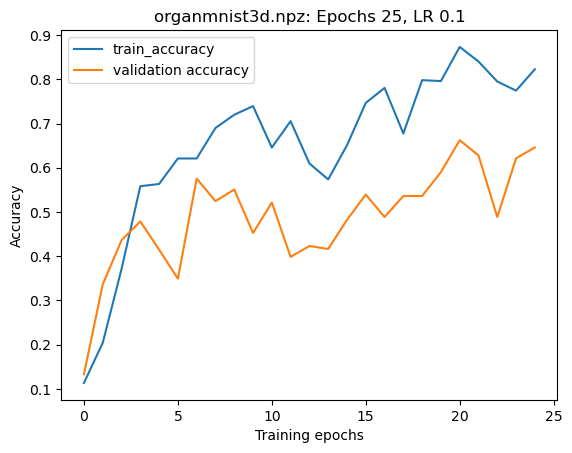

Training time: 3.9 seconds
Evaluation time: 0.09 seconds
Accuracy: 64.59, Loss: 35.72231, Epochs: 25, LR 0.1

Training... organmnist3d.npz: Epochs 50, LR 0.1


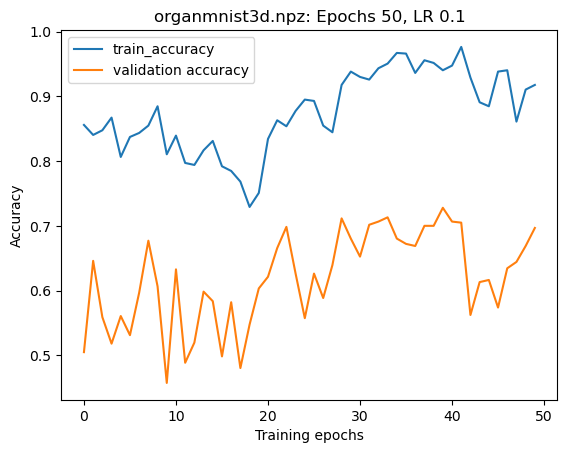

Training time: 6.72 seconds
Evaluation time: 0.14 seconds
Accuracy: 69.672, Loss: 24.63009, Epochs: 50, LR 0.1

Training... organmnist3d.npz: Epochs 100, LR 0.1


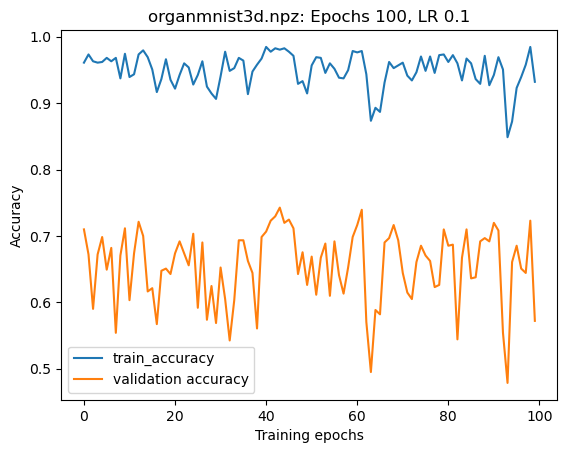

Training time: 13.66 seconds
Evaluation time: 0.06 seconds
Accuracy: 57.213, Loss: 63.43469, Epochs: 100, LR 0.1

Training... organmnist3d.npz: Epochs 150, LR 0.1


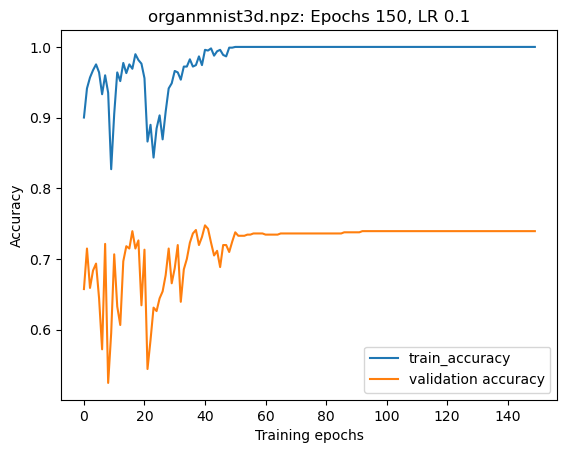

Training time: 20.48 seconds
Evaluation time: 0.06 seconds
Accuracy: 73.934, Loss: 35.56622, Epochs: 150, LR 0.1


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 21952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       2,809,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 11)                  │             715 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,823,115 (10.77 MB)

 Trainable params: 2,823,115 (10.77 MB)

 Non-trainable params: 0 (0.00 B)


Training... organmnist3d.npz: Epochs 25, LR 0.01


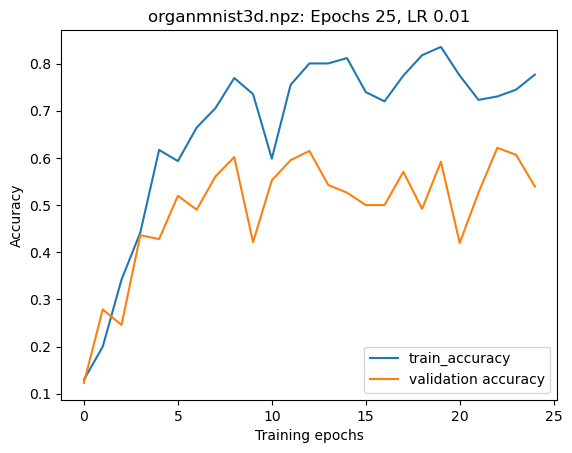

Training time: 3.88 seconds
Evaluation time: 0.06 seconds
Accuracy: 53.934, Loss: 49.3479, Epochs: 25, LR 0.01

Training... organmnist3d.npz: Epochs 50, LR 0.01


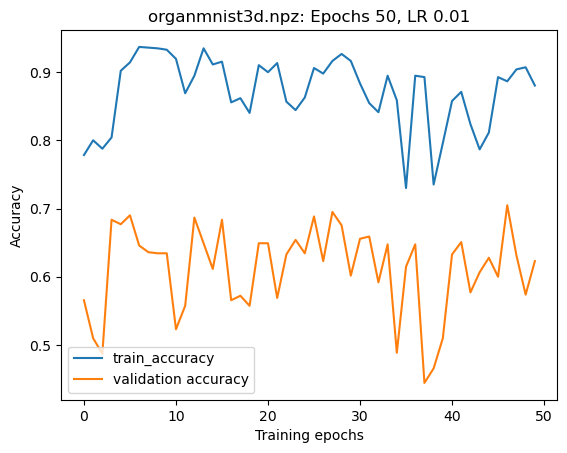

Training time: 6.75 seconds
Evaluation time: 0.06 seconds
Accuracy: 62.295, Loss: 46.0034, Epochs: 50, LR 0.01

Training... organmnist3d.npz: Epochs 100, LR 0.01


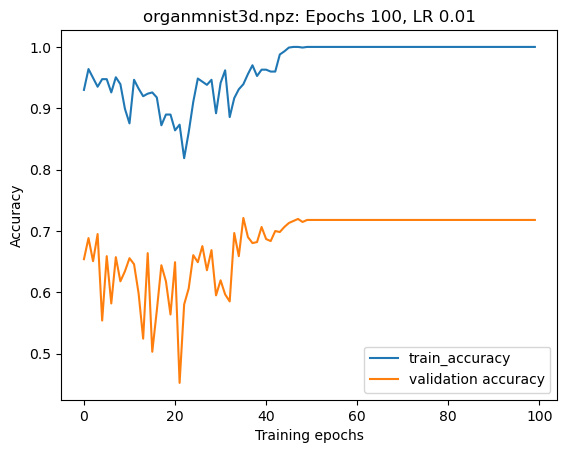

Training time: 13.16 seconds
Evaluation time: 0.06 seconds
Accuracy: 71.803, Loss: 28.72795, Epochs: 100, LR 0.01

Training... organmnist3d.npz: Epochs 150, LR 0.01


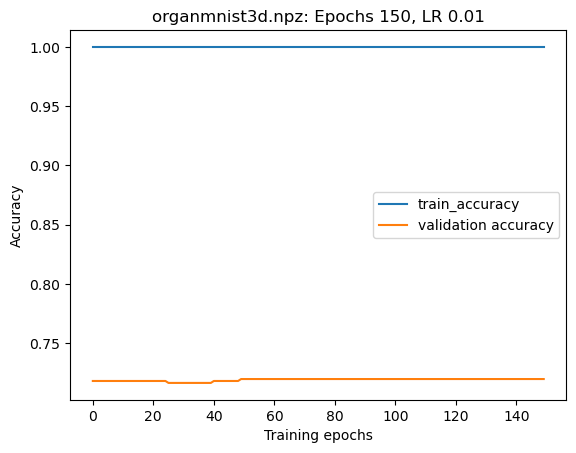

Training time: 19.71 seconds
Evaluation time: 0.06 seconds
Accuracy: 71.967, Loss: 28.70641, Epochs: 150, LR 0.01


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 21952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       2,809,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 11)                  │             715 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,823,115 (10.77 MB)

 Trainable params: 2,823,115 (10.77 MB)

 Non-trainable params: 0 (0.00 B)


Training... organmnist3d.npz: Epochs 25, LR 0.001


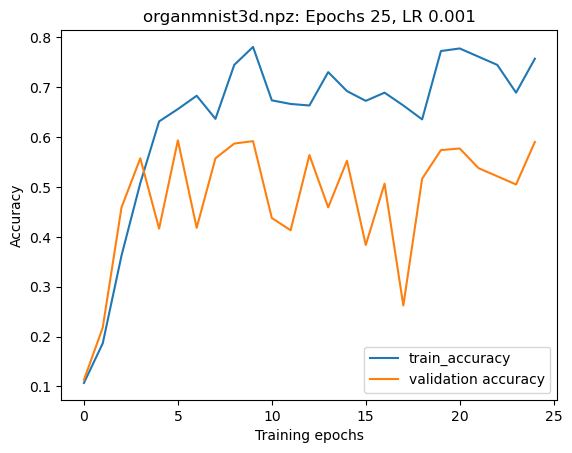

Training time: 3.88 seconds
Evaluation time: 0.06 seconds
Accuracy: 59.016, Loss: 41.06574, Epochs: 25, LR 0.001

Training... organmnist3d.npz: Epochs 50, LR 0.001


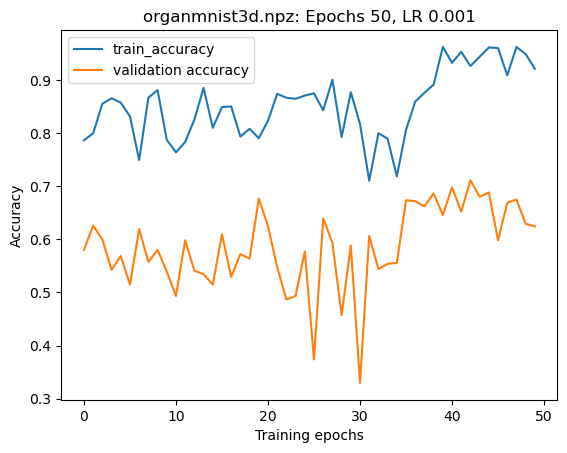

Training time: 6.63 seconds
Evaluation time: 0.06 seconds
Accuracy: 62.459, Loss: 40.94867, Epochs: 50, LR 0.001

Training... organmnist3d.npz: Epochs 100, LR 0.001


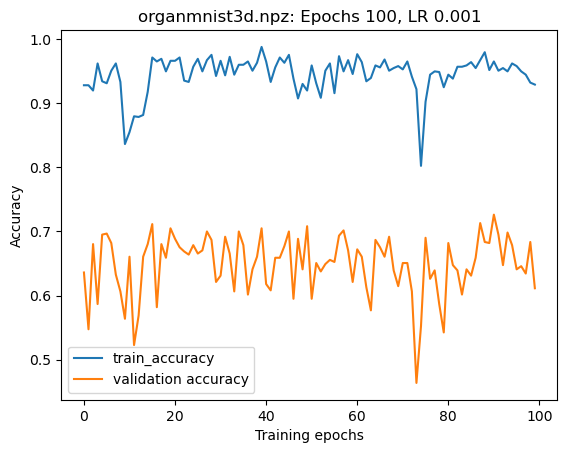

Training time: 13.26 seconds
Evaluation time: 0.07 seconds
Accuracy: 61.148, Loss: 56.48637, Epochs: 100, LR 0.001

Training... organmnist3d.npz: Epochs 150, LR 0.001


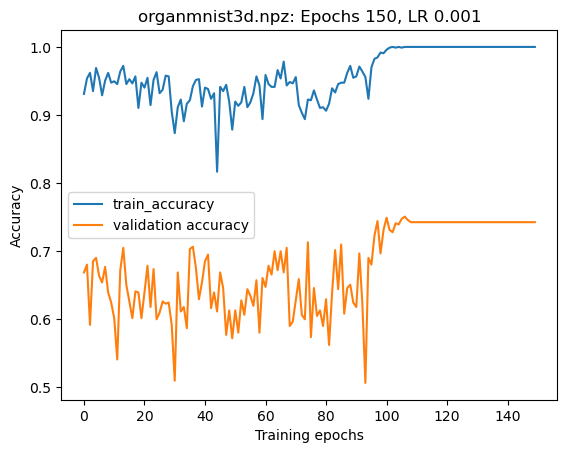

Training time: 19.68 seconds
Evaluation time: 0.06 seconds
Accuracy: 74.262, Loss: 32.31862, Epochs: 150, LR 0.001

-------------------------------------------------------
retinamnist_128.npz
  train_images: 1080 RGB images:128x128x3
  val_images: 120 RGB images:128x128x3
  test_images: 400 RGB images:128x128x3

Label:  0


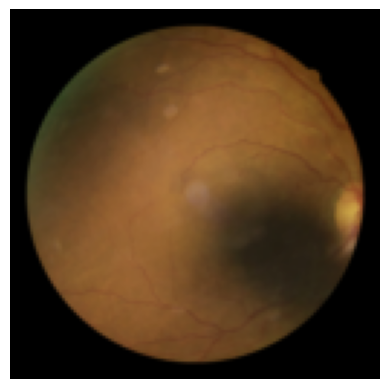

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 49152)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,291,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,304,325 (24.05 MB)

 Trainable params: 6,304,325 (24.05 MB)

 Non-trainable params: 0 (0.00 B)


Training... retinamnist_128.npz: Epochs 25, LR 0.1


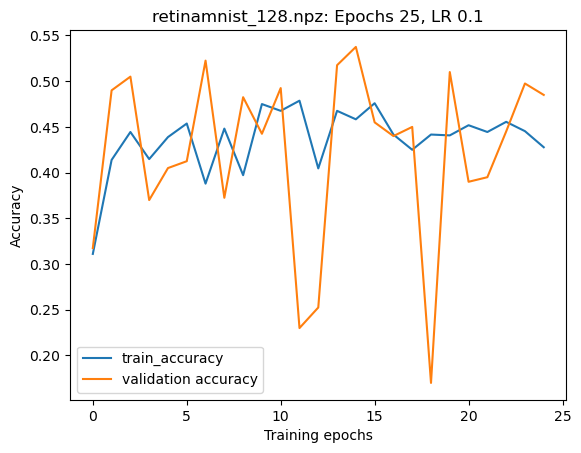

Training time: 8.02 seconds
Evaluation time: 0.09 seconds
Accuracy: 48.5, Loss: 31.60228, Epochs: 25, LR 0.1

Training... retinamnist_128.npz: Epochs 50, LR 0.1


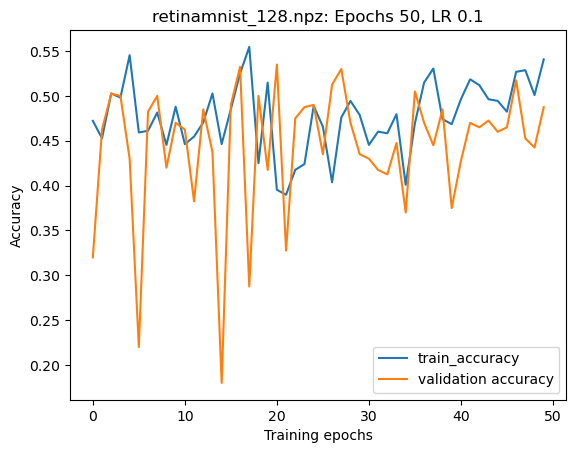

Training time: 14.88 seconds
Evaluation time: 0.07 seconds
Accuracy: 48.75, Loss: 3.57607, Epochs: 50, LR 0.1

Training... retinamnist_128.npz: Epochs 100, LR 0.1


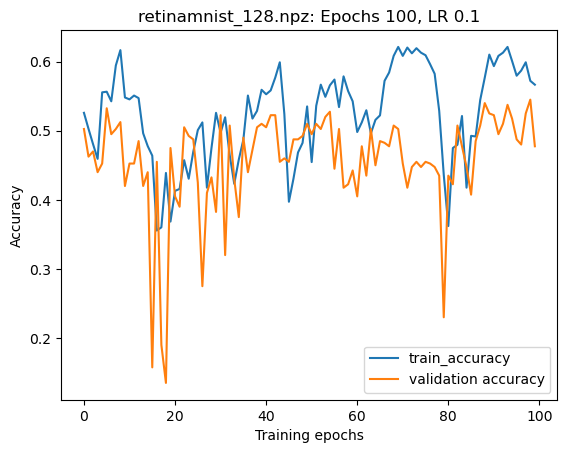

Training time: 29.81 seconds
Evaluation time: 0.07 seconds
Accuracy: 47.75, Loss: 1.66387, Epochs: 100, LR 0.1

Training... retinamnist_128.npz: Epochs 150, LR 0.1


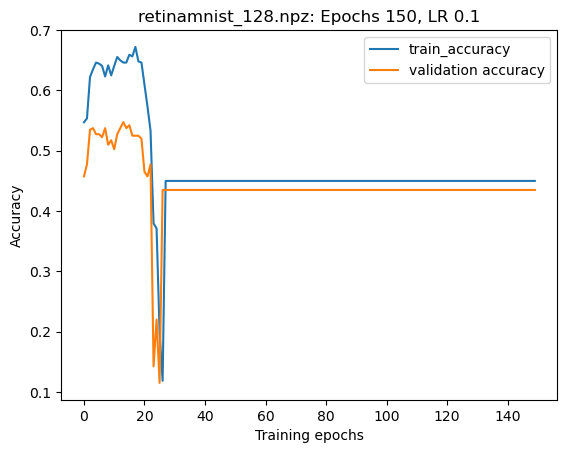

Training time: 44.57 seconds
Evaluation time: 0.07 seconds
Accuracy: 43.5, Loss: 1.44482, Epochs: 150, LR 0.1


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 49152)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,291,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,304,325 (24.05 MB)

 Trainable params: 6,304,325 (24.05 MB)

 Non-trainable params: 0 (0.00 B)


Training... retinamnist_128.npz: Epochs 25, LR 0.01


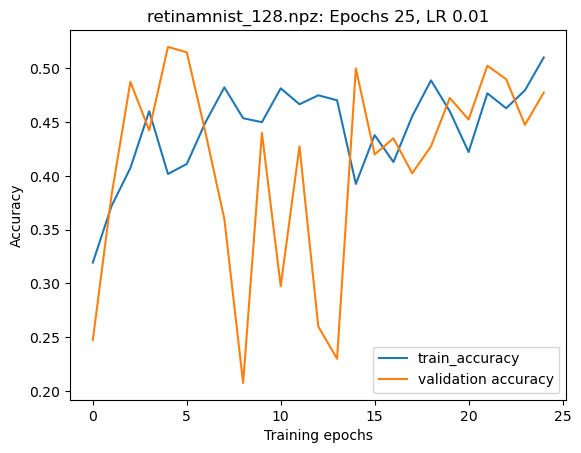

Training time: 8.01 seconds
Evaluation time: 0.07 seconds
Accuracy: 47.75, Loss: 41.48546, Epochs: 25, LR 0.01

Training... retinamnist_128.npz: Epochs 50, LR 0.01


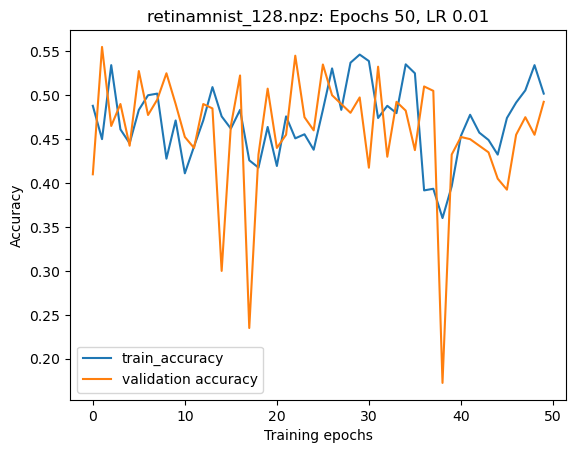

Training time: 14.89 seconds
Evaluation time: 0.07 seconds
Accuracy: 49.25, Loss: 1.51743, Epochs: 50, LR 0.01

Training... retinamnist_128.npz: Epochs 100, LR 0.01


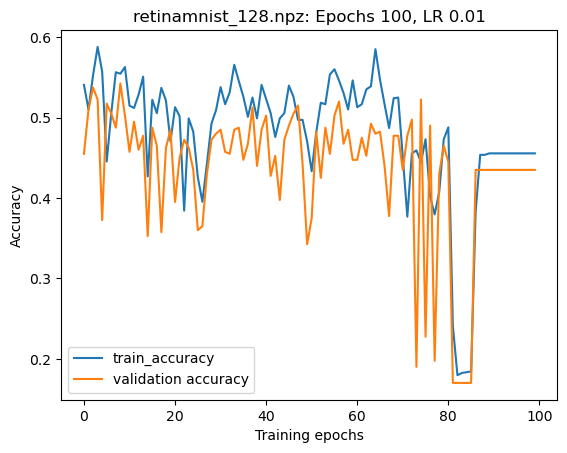

Training time: 29.74 seconds
Evaluation time: 0.07 seconds
Accuracy: 43.5, Loss: 1.40519, Epochs: 100, LR 0.01

Training... retinamnist_128.npz: Epochs 150, LR 0.01


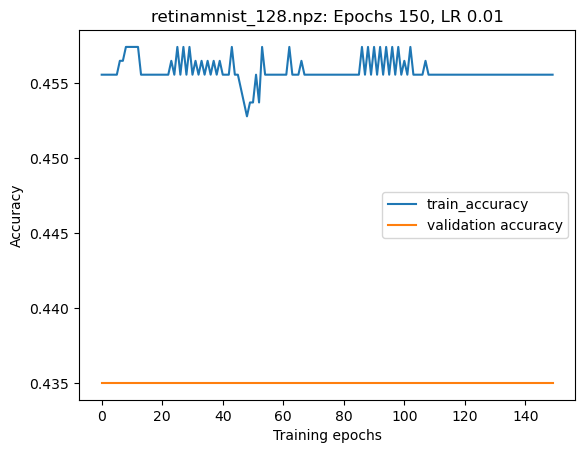

Training time: 44.52 seconds
Evaluation time: 0.07 seconds
Accuracy: 43.5, Loss: 1.4054, Epochs: 150, LR 0.01


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 49152)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,291,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,304,325 (24.05 MB)

 Trainable params: 6,304,325 (24.05 MB)

 Non-trainable params: 0 (0.00 B)


Training... retinamnist_128.npz: Epochs 25, LR 0.001


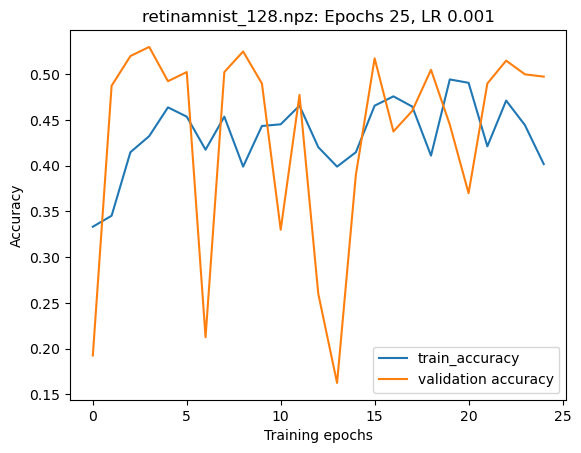

Training time: 7.88 seconds
Evaluation time: 0.07 seconds
Accuracy: 49.75, Loss: 61.92596, Epochs: 25, LR 0.001

Training... retinamnist_128.npz: Epochs 50, LR 0.001


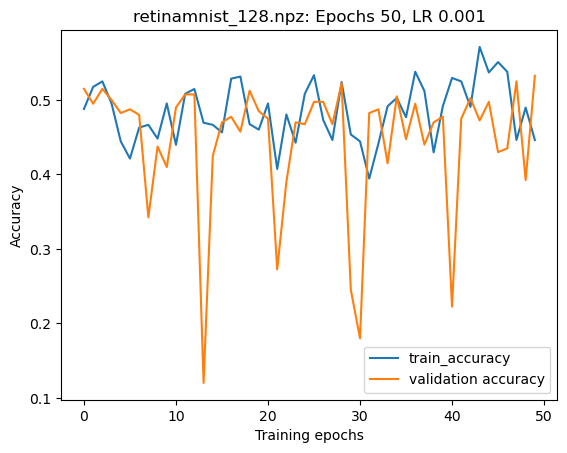

Training time: 14.8 seconds
Evaluation time: 0.07 seconds
Accuracy: 53.25, Loss: 5.93204, Epochs: 50, LR 0.001

Training... retinamnist_128.npz: Epochs 100, LR 0.001


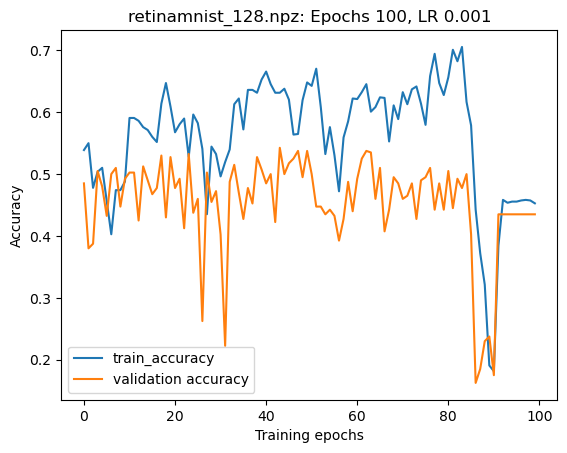

Training time: 29.6 seconds
Evaluation time: 0.07 seconds
Accuracy: 43.5, Loss: 1.40544, Epochs: 100, LR 0.001

Training... retinamnist_128.npz: Epochs 150, LR 0.001


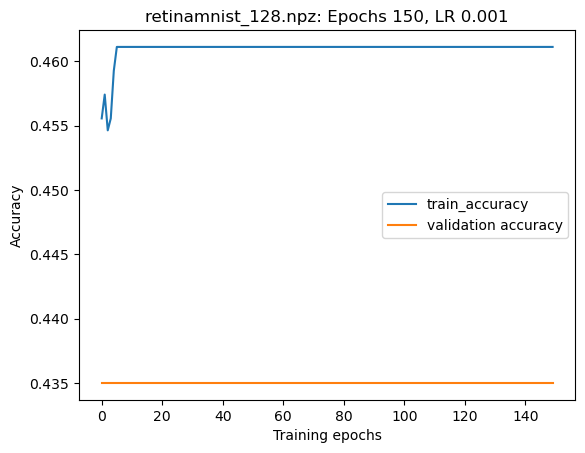

Training time: 44.16 seconds
Evaluation time: 0.07 seconds
Accuracy: 43.5, Loss: 1.40535, Epochs: 150, LR 0.001
DONE: 2941.0892214775085 seconds


In [196]:
# NOTE: 'chestmnist.npz', # image, label size length mismatch, not used here
files = ['bloodmnist.npz', 'breastmnist.npz', 'dermamnist.npz', 'octmnist.npz', 'organsmnist.npz', \
         'nodulemnist3d.npz', 'organmnist3d.npz', 'retinamnist_128.npz']
#files = ['bloodmnist.npz', 'breastmnist.npz']
#files = ['breastmnist.npz']

start_run = time.time()

rslt = {}
first_write = True

dtmin = get_time_with_minutes(get_localdate_str())
outfile = "FFNN-" + dtmin +".csv"

for fn in files:
    csv_info = process_file(fn)

    # Append the new data to an existing CSV file
    df = pd.DataFrame(csv_info, columns=['fn','lr','epochs','accuracy','loss','train time'])
    if (first_write):
        # write to file (create or overwrite)
        df = pd.DataFrame(csv_info, columns=['fn','lr','epochs','accuracy','loss','train time'])
        df.to_csv(outfile, index=False)
        first_write = False
    else:
        # append to file
        df.to_csv(outfile, mode='a', index=False, header=False)

end_run = time.time() - start_run

print(f"DONE: {end_run} seconds")

In [256]:
def display_best(best_acc_indx, best_loss_indx):
    print(f"        best accuracy: Index {best_acc_indx}, least loss: Index {best_loss_indx}")

df = pd.read_csv(outfile)

lr = 'lr'
eps = 'epochs'
ac = 'accuracy'
ls = 'loss'
tt = 'train time'
filen = ""

best_acc = 0.0
best_loss = 100.0
best_acc_indx = 0
best_loss_indx = 0

print("Feed Forward Neural Network Comparison by Filename")
for index, row in df.iterrows():
    if not np.isnan(row['lr']):
        if (row['fn'] != filen):
            if (filen != ""):
                display_best(best_acc_indx, best_loss_indx)
            filen = row['fn']
            print(f"\n{row['fn']}")
            print(f"  index\t{lr}\t\t{eps}\t{ac}\t{ls}\t\t{tt}")
            
            best_acc = 0.0
            best_loss = 100.0
        else:
            tbs = '\t\t'
            if row[ls] >= 10.0:
                tbs = '\t'
            print(f"  {index}\t{row[lr]:.3f}\t\t{int(row[eps]):03}\t{row[ac]}\t\t{row[ls]:.5f}{tbs}{row[tt]} secs")
            if row[ac] > best_acc:
                best_acc = row[ac]
                best_acc_indx = index
            if row[ls] < best_loss:
                best_loss = row[ls]
                best_loss_indx = index
# for last file
display_best(best_acc_indx, best_loss_indx)

Feed Forward Neural Network Comparison by Filename

bloodmnist.npz
  index	lr		epochs	accuracy	loss		train time
  2	0.100		050	74.8		0.71604		16.74 secs
  3	0.100		100	72.81		0.86646		33.67 secs
  4	0.100		150	82.49		0.57898		51.08 secs
  5	0.010		025	69.04		0.86651		9.42 secs
  6	0.010		050	75.12		0.66975		17.54 secs
  7	0.010		100	76.12		0.68295		35.13 secs
  8	0.010		150	79.42		0.61652		52.6 secs
  9	0.001		025	80.5		0.56530		9.38 secs
  10	0.001		050	79.57		0.53982		17.86 secs
  11	0.001		100	83.95		0.47366		36.07 secs
  12	0.001		150	83.16		0.54364		53.16 secs
        best accuracy: Index 11, least loss: Index 11

breastmnist.npz
  index	lr		epochs	accuracy	loss		train time
  15	0.100		050	80.13		0.83516		2.73 secs
  16	0.100		100	82.05		1.05795		5.36 secs
  17	0.100		150	82.69		1.63701		8.06 secs
  18	0.010		025	73.08		1.93608		1.97 secs
  19	0.010		050	80.77		2.09200		2.66 secs
  20	0.010		100	79.49		1.48855		5.44 secs
  21	0.010		150	76.28		3.44124		7.9 secs
  22	0.001		025	79.